# <div style="text-align: center;"> **CNN MODELS** </div>

----------------------------

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../scr'))
from import_images import create_image_dataset
from image_loader import LoadImage
from image_preprocesser import preprocess_image, apply_preprocessing
from callbacks_training_CNN import create_reduce_lr_callback, create_early_stopping_callback, establish_checkpoints , train_model
from metrics_CNN import plot_training_history, plot_confusion_matrix, plot_auc_curve
from extract_features import extract_features
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50, MobileNetV3Small
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

2025-02-28 08:29:26.223660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740727766.246141  169770 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740727766.252214  169770 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 08:29:26.269439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Directories 
train_dir = "../Data/Processed/ml-dp/train"
val_dir = "../Data/Processed/ml-dp/val"
test_dir = "../Data/Processed/ml-dp/test"

### **Load and Preprocessing images**

In [3]:
#Import images
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None)
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None)
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None)
class_names = train_ds.class_names

Found 2455 files belonging to 2 classes.


I0000 00:00:1740476358.933963 2780122 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [4]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(256, 256)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

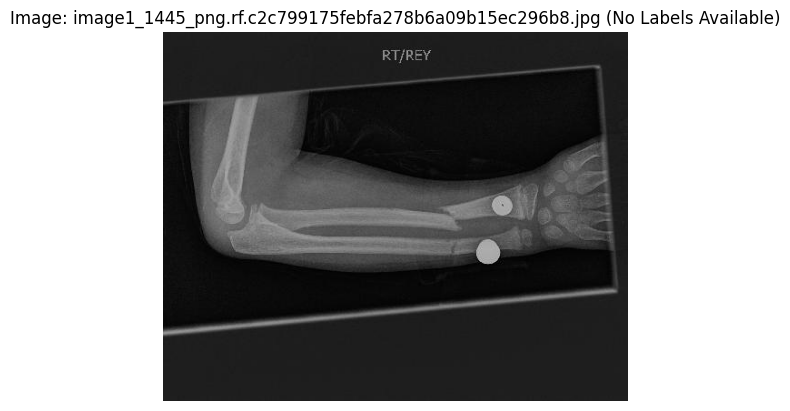

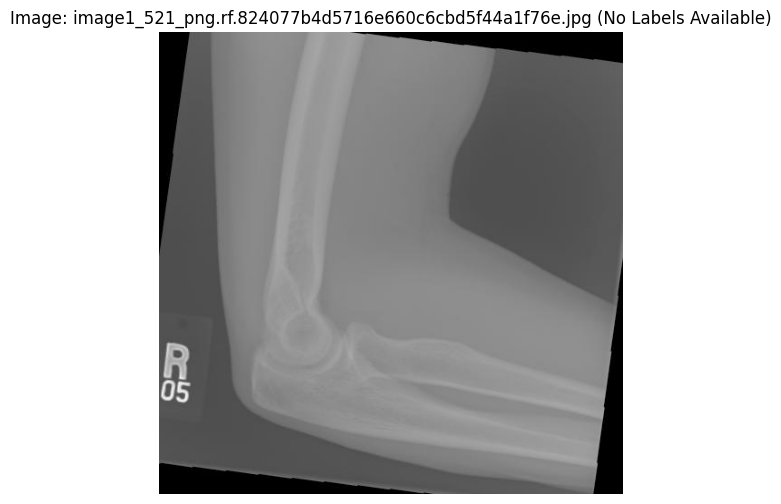

In [8]:
#Plot random images
loader = LoadImage(train_dir)
loader.plot_images_with_bboxes() 


----

### **Contruct a CNN**

### *Model 1*

In [5]:
#Construct the model 
model_CNN1 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN1.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN1.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN1.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN1.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN1.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN1.add(layers.Dense(1, activation='sigmoid'))

model_CNN1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

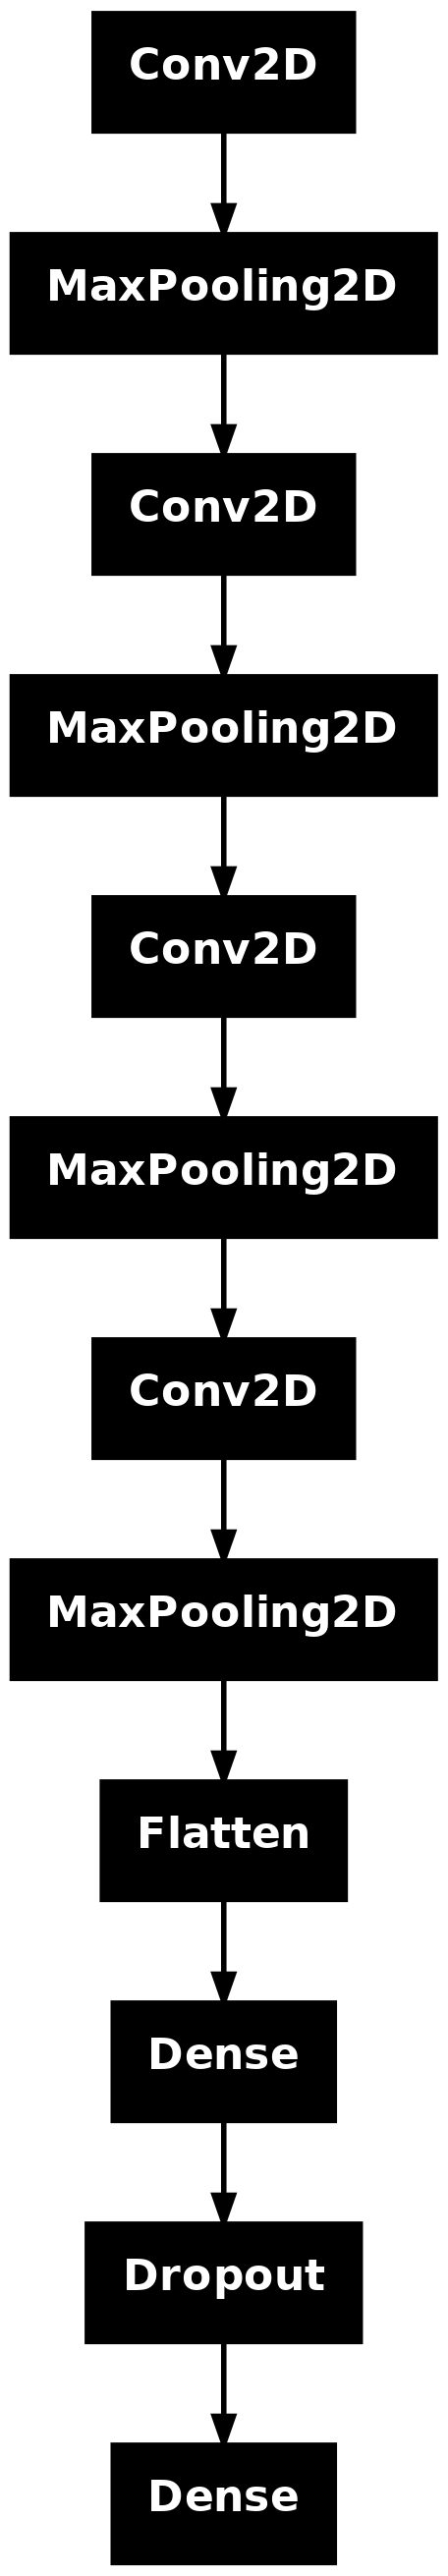

In [6]:
tf.keras.utils.plot_model(model_CNN1)

In [6]:
model_CNN1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [7]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback()

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback()

#Train the model 
history = train_model(model_CNN1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


I0000 00:00:1740476375.600632 2783023 service.cc:148] XLA service 0x7f520000cdf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740476375.600723 2783023 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-02-25 10:39:35.744530: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740476375.951247 2783023 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-25 10:39:36.322994: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"

  2/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4875 - loss: 0.9074 

I0000 00:00:1740476380.069623 2783023 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


121/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4972 - loss: 0.7420

2025-02-25 10:39:45.603674: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 10:39:45.671794: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,32,127,127]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4972 - loss: 0.7415

2025-02-25 10:39:48.841948: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-02-25 10:39:48.841991: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-25 10:39:48.842005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:39:48.842017: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trac

150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.4977 - loss: 0.7360 - val_accuracy: 0.4959 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 2/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5006 - loss: 0.6952

2025-02-25 10:39:56.960135: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-25 10:39:56.960169: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:39:56.960187: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5033 - loss: 0.6947 - val_accuracy: 0.5236 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 3/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5261 - loss: 0.6997

2025-02-25 10:40:02.673403: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:40:02.673436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5248 - loss: 0.6989 - val_accuracy: 0.5626 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 4/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5453 - loss: 0.6830

2025-02-25 10:40:08.503565: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-25 10:40:08.503600: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:40:08.503621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5489 - loss: 0.6818 - val_accuracy: 0.5789 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 5/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5803 - loss: 0.6671

2025-02-25 10:40:14.336836: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:40:14.336876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5857 - loss: 0.6630 - val_accuracy: 0.5789 - val_loss: 0.7221 - learning_rate: 0.0010
Epoch 6/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6047 - loss: 0.6594

2025-02-25 10:40:20.093236: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:40:20.093275: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6133 - loss: 0.6508 - val_accuracy: 0.5756 - val_loss: 0.7434 - learning_rate: 0.0010
Epoch 7/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6372 - loss: 0.6093

2025-02-25 10:40:25.891390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:40:25.891429: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6449 - loss: 0.6011 - val_accuracy: 0.5789 - val_loss: 0.8299 - learning_rate: 0.0010


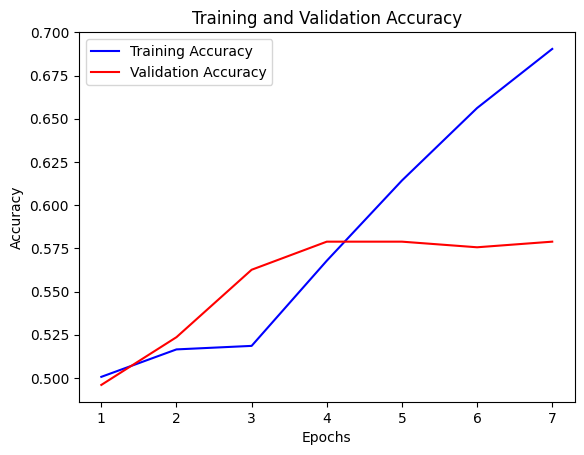

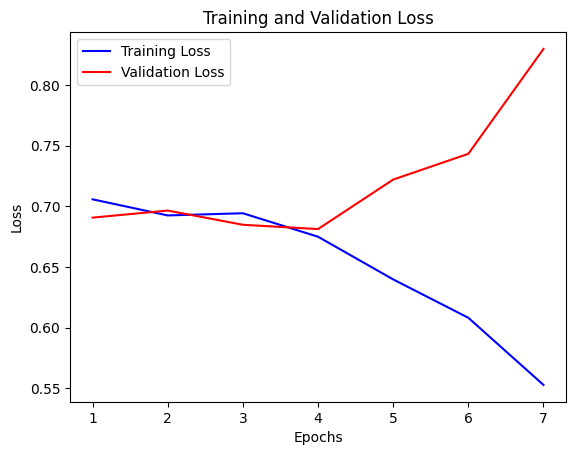

In [8]:
plot_training_history(history)

34/39 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2025-02-25 10:40:42.090936: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 10:40:42.222014: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,32,127,127]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Accuracy on test dataset: 0.4954

Classification Report:
               precision    recall  f1-score   support

    fracture       0.50      0.68      0.58       387
  nofracture       0.49      0.31      0.38       380

    accuracy                           0.50       767
   macro avg       0.49      0.49      0.48       767
weighted avg       0.49      0.50      0.48       767



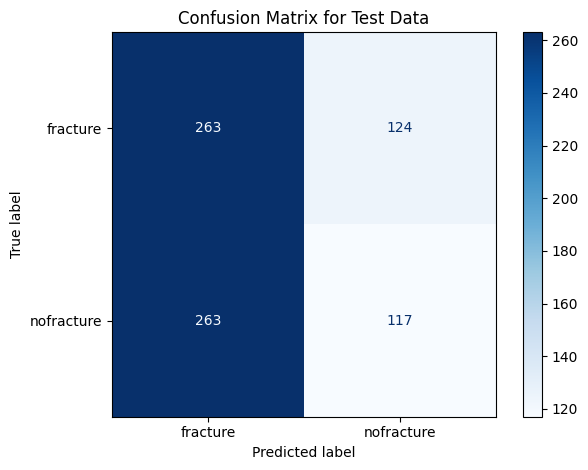

In [9]:
accuracy, class_report, cm = plot_confusion_matrix(model_CNN1, test_ds, class_names = class_names)

 7/39 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

2025-02-25 10:41:00.416467: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
AUC: 0.4938


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


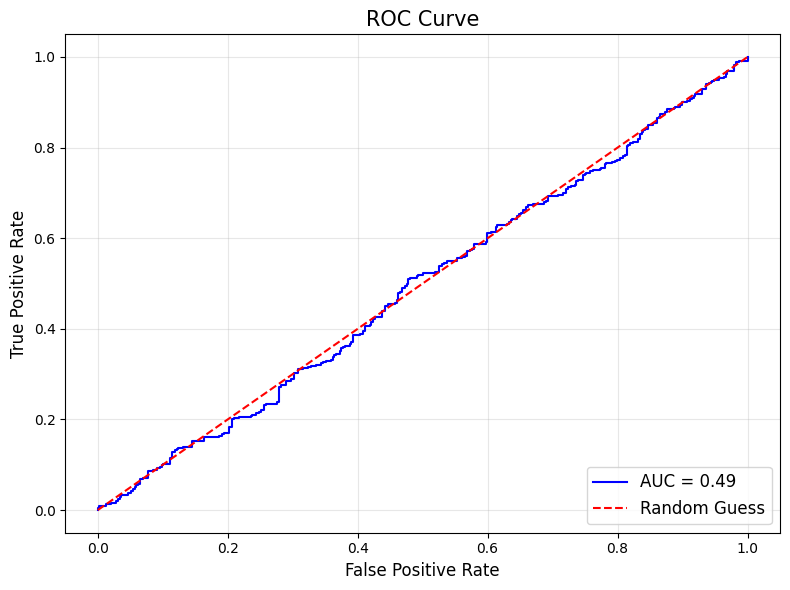

In [10]:
auc = plot_auc_curve(model_CNN1, test_ds)

------

In [11]:
#Same model but patient 10 instead of 3

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = train_model(model_CNN1, train_ds, epochs = 100, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5930 - loss: 0.6632

2025-02-25 10:41:10.939276: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:41:10.939314: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5979 - loss: 0.6582 - val_accuracy: 0.5902 - val_loss: 0.7132 - learning_rate: 5.0000e-04
Epoch 2/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6249 - loss: 0.6373

2025-02-25 10:41:17.004245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:41:17.004290: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6291 - loss: 0.6312 - val_accuracy: 0.5772 - val_loss: 0.7686 - learning_rate: 5.0000e-04
Epoch 3/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6529 - loss: 0.6120

2025-02-25 10:41:22.916173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:41:22.916228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6610 - loss: 0.6034 - val_accuracy: 0.5935 - val_loss: 0.7460 - learning_rate: 5.0000e-04
Epoch 4/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7004 - loss: 0.5384

2025-02-25 10:41:28.683588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:41:28.683634: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7071 - loss: 0.5293 - val_accuracy: 0.5984 - val_loss: 1.0043 - learning_rate: 5.0000e-04
Epoch 5/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7347 - loss: 0.5030

2025-02-25 10:41:34.480675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:41:34.480719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7451 - loss: 0.4873 - val_accuracy: 0.6081 - val_loss: 1.1342 - learning_rate: 5.0000e-04
Epoch 6/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8268 - loss: 0.3734

2025-02-25 10:41:40.265173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:41:40.265218: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8321 - loss: 0.3627 - val_accuracy: 0.6114 - val_loss: 1.4682 - learning_rate: 5.0000e-04
Epoch 7/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8617 - loss: 0.2975

2025-02-25 10:41:46.030117: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:41:46.030156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8673 - loss: 0.2874 - val_accuracy: 0.6439 - val_loss: 1.5803 - learning_rate: 5.0000e-04
Epoch 8/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8973 - loss: 0.2489

2025-02-25 10:41:51.849011: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-25 10:41:51.849041: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:41:51.849056: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9021 - loss: 0.2377 - val_accuracy: 0.6211 - val_loss: 1.8107 - learning_rate: 5.0000e-04
Epoch 9/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9274 - loss: 0.1824

2025-02-25 10:41:57.729249: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:41:57.729294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9309 - loss: 0.1750 - val_accuracy: 0.6211 - val_loss: 1.9901 - learning_rate: 5.0000e-04
Epoch 10/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9512 - loss: 0.1408

2025-02-25 10:42:03.526294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:42:03.526331: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9530 - loss: 0.1358 - val_accuracy: 0.6504 - val_loss: 1.9780 - learning_rate: 5.0000e-04
Epoch 11/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9665 - loss: 0.1025

2025-02-25 10:42:09.321581: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:42:09.321616: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9672 - loss: 0.1024 - val_accuracy: 0.6520 - val_loss: 1.7029 - learning_rate: 5.0000e-04


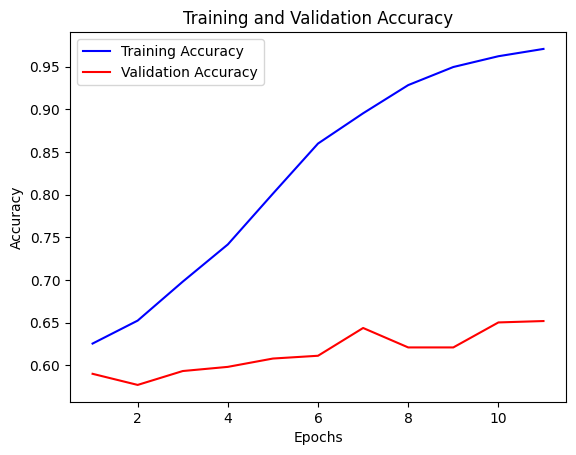

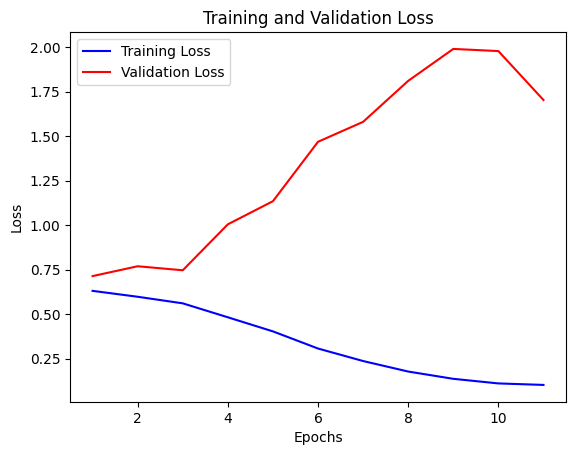

In [12]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy on test dataset: 0.4967

Classification Report:
               precision    recall  f1-score   support

    fracture       0.50      0.41      0.45       387
  nofracture       0.49      0.59      0.54       380

    accuracy                           0.50       767
   macro avg       0.50      0.50      0.49       767
weighted avg       0.50      0.50      0.49       767



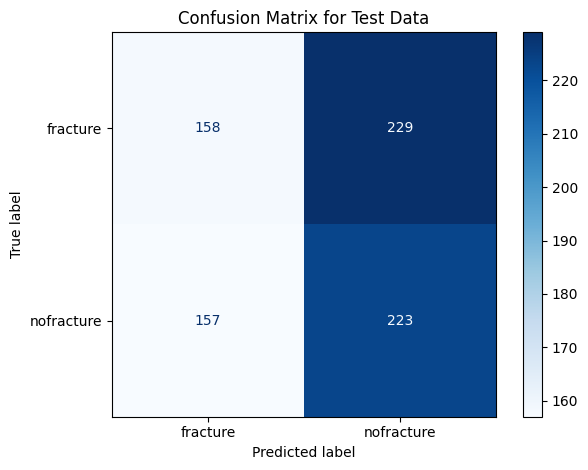

In [13]:
accuracy, class_report, cm = plot_confusion_matrix(model_CNN1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
AUC: 0.4895


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


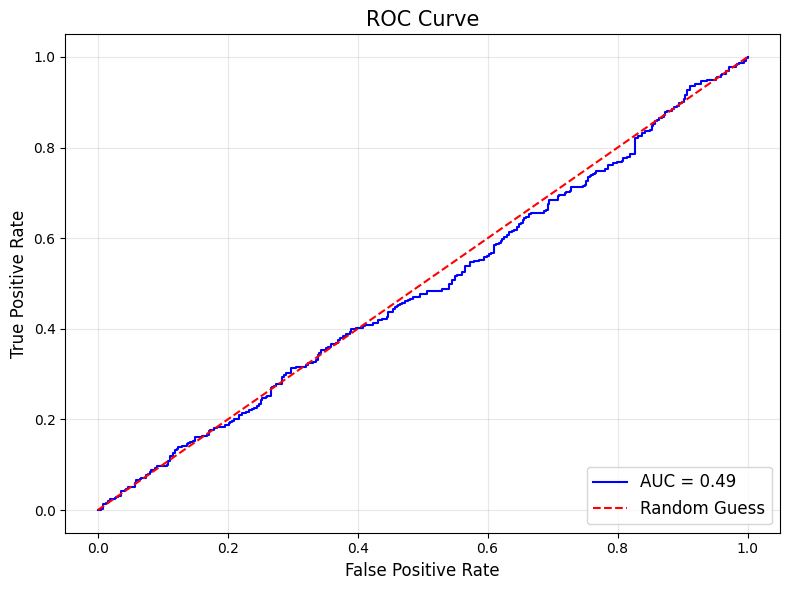

In [14]:
auc = plot_auc_curve(model_CNN1, test_ds)

----

In [15]:
optimizer = Adam(learning_rate=1e-4)
model_CNN1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [16]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6157 - loss: 0.6586

2025-02-25 10:42:47.640663: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.6229 - loss: 0.6491 - val_accuracy: 0.6016 - val_loss: 0.7147 - learning_rate: 1.0000e-04
Epoch 2/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6355 - loss: 0.6246

2025-02-25 10:42:54.152928: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6420 - loss: 0.6187 - val_accuracy: 0.5886 - val_loss: 0.7152 - learning_rate: 1.0000e-04
Epoch 3/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6536 - loss: 0.6047

2025-02-25 10:42:59.912787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6607 - loss: 0.5972 - val_accuracy: 0.5902 - val_loss: 0.7248 - learning_rate: 1.0000e-04
Epoch 4/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6888 - loss: 0.5865

2025-02-25 10:43:05.688989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:43:05.689032: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6944 - loss: 0.5799 - val_accuracy: 0.5951 - val_loss: 0.7288 - learning_rate: 1.0000e-04
Epoch 5/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6904 - loss: 0.5673

2025-02-25 10:43:11.470613: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6968 - loss: 0.5587 - val_accuracy: 0.6033 - val_loss: 0.7483 - learning_rate: 1.0000e-04
Epoch 6/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7223 - loss: 0.5323

2025-02-25 10:43:17.272692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7279 - loss: 0.5245 - val_accuracy: 0.5984 - val_loss: 0.7694 - learning_rate: 1.0000e-04


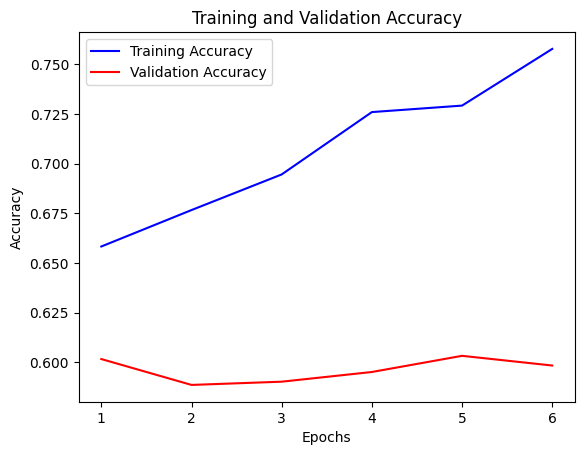

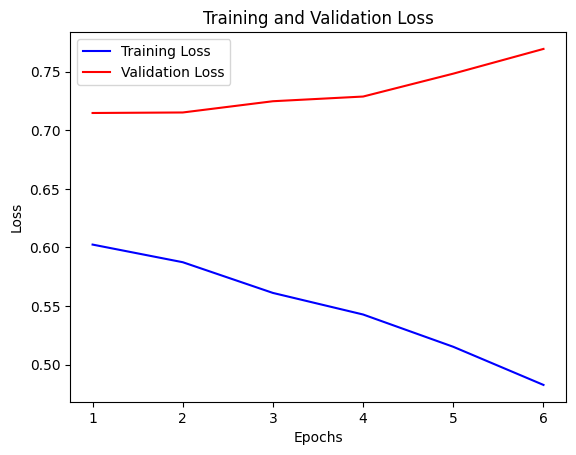

In [17]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Accuracy on test dataset: 0.5033

Classification Report:
               precision    recall  f1-score   support

    fracture       0.51      0.48      0.50       387
  nofracture       0.50      0.52      0.51       380

    accuracy                           0.50       767
   macro avg       0.50      0.50      0.50       767
weighted avg       0.50      0.50      0.50       767



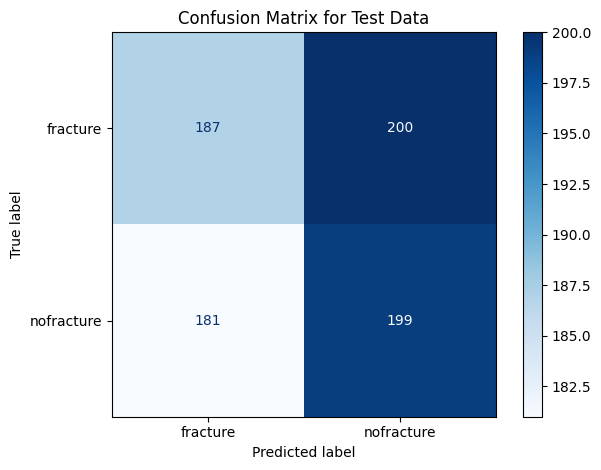

In [18]:
accuracy, class_report, cm = plot_confusion_matrix(model_CNN1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
AUC: 0.4964


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


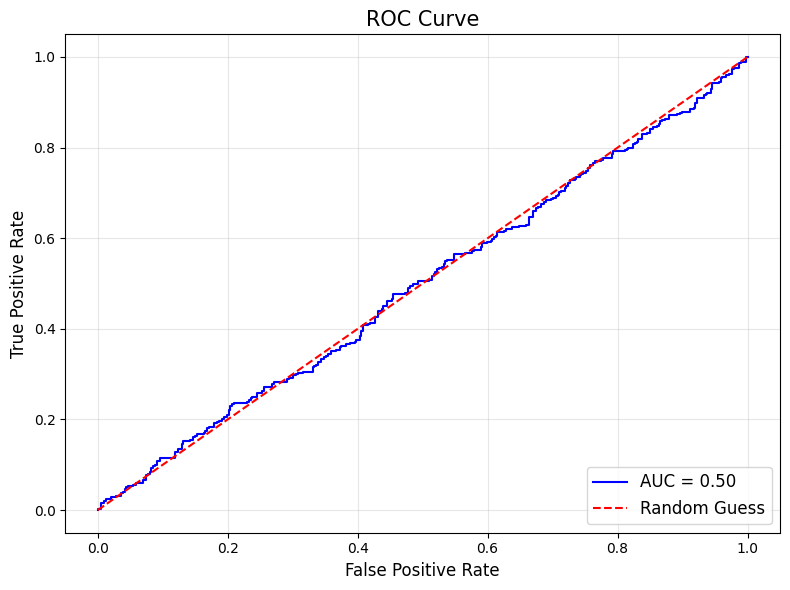

In [19]:
auc = plot_auc_curve(model_CNN1, test_ds)

------------

### *Model 2*

In [20]:
#Construct the model 
model_CNN2 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN2.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Dropout(0.3)) #add a dropout
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN2.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN2.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN2.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

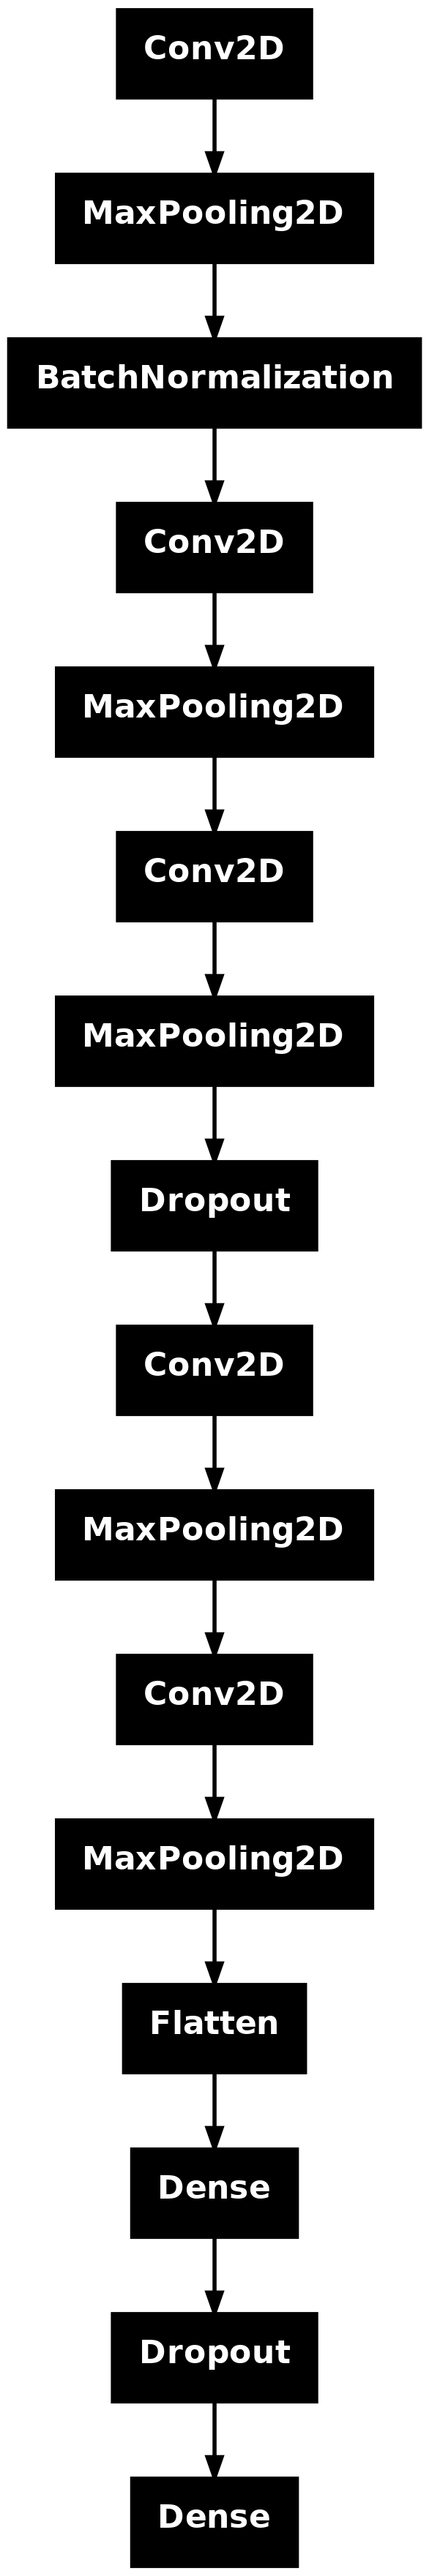

In [35]:
tf.keras.utils.plot_model(model_CNN2)

In [21]:
optimizer = Adam(learning_rate=1e-3)
model_CNN2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN2, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2025-02-25 10:43:53.257924: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


122/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4870 - loss: 0.7628

2025-02-25 10:44:01.340686: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4871 - loss: 0.7624

2025-02-25 10:44:03.711838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2025-02-25 10:44:04.106786: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earlies

150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.4878 - loss: 0.7538 - val_accuracy: 0.5041 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5064 - loss: 0.6946

2025-02-25 10:44:10.617290: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:44:10.617337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5087 - loss: 0.6944 - val_accuracy: 0.5041 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 3/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4960 - loss: 0.6949

2025-02-25 10:44:16.457259: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:44:16.457298: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4984 - loss: 0.6947 - val_accuracy: 0.5041 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 4/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5169 - loss: 0.6969

2025-02-25 10:44:22.312358: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:44:22.312397: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5161 - loss: 0.6966 - val_accuracy: 0.5398 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 5/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4985 - loss: 0.6939

2025-02-25 10:44:28.215988: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-25 10:44:28.216020: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:44:28.216039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5013 - loss: 0.6936 - val_accuracy: 0.5561 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 6/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5396 - loss: 0.6917

2025-02-25 10:44:34.107893: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:44:34.107943: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5398 - loss: 0.6910 - val_accuracy: 0.5707 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 7/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5425 - loss: 0.7121

2025-02-25 10:44:39.930211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:44:39.930248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5417 - loss: 0.7086 - val_accuracy: 0.5285 - val_loss: 0.6861 - learning_rate: 0.0010
Epoch 8/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5654 - loss: 0.6837

2025-02-25 10:44:45.756261: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:44:45.756299: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5652 - loss: 0.6836 - val_accuracy: 0.5675 - val_loss: 0.6800 - learning_rate: 0.0010
Epoch 9/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5461 - loss: 0.6934

2025-02-25 10:44:51.595009: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:44:51.595044: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5436 - loss: 0.6937 - val_accuracy: 0.5203 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 10/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5177 - loss: 0.6939

2025-02-25 10:44:57.411101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:44:57.411150: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5169 - loss: 0.6939 - val_accuracy: 0.5089 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 11/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5007 - loss: 0.6955

2025-02-25 10:45:03.251923: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:45:03.251968: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5011 - loss: 0.6954 - val_accuracy: 0.5138 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 12/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5277 - loss: 0.6909

2025-02-25 10:45:09.108039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:45:09.108077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5256 - loss: 0.6912 - val_accuracy: 0.4829 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 13/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5113 - loss: 0.6946

2025-02-25 10:45:14.935316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:45:14.935352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5122 - loss: 0.6948 - val_accuracy: 0.5041 - val_loss: 0.6932 - learning_rate: 0.0010


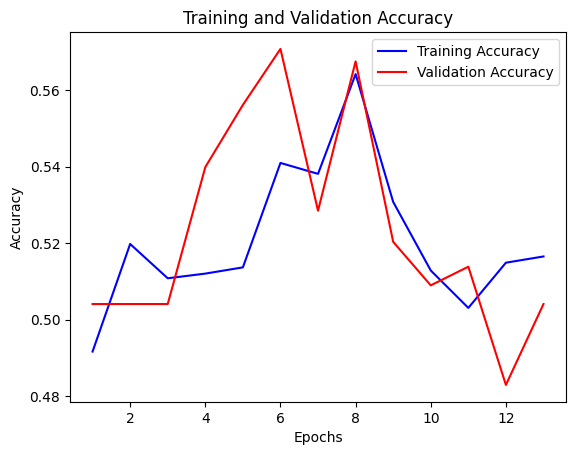

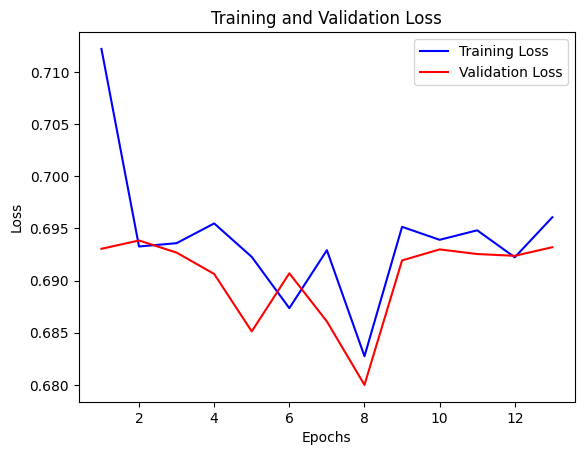

In [23]:
plot_training_history(history)

---------

### *Model 3*

In [24]:
#Construct the model 
model_CNN3 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN3.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))) #L2 regularization
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Dropout(0.4)) #add a dropout
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN3.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN3.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN3.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

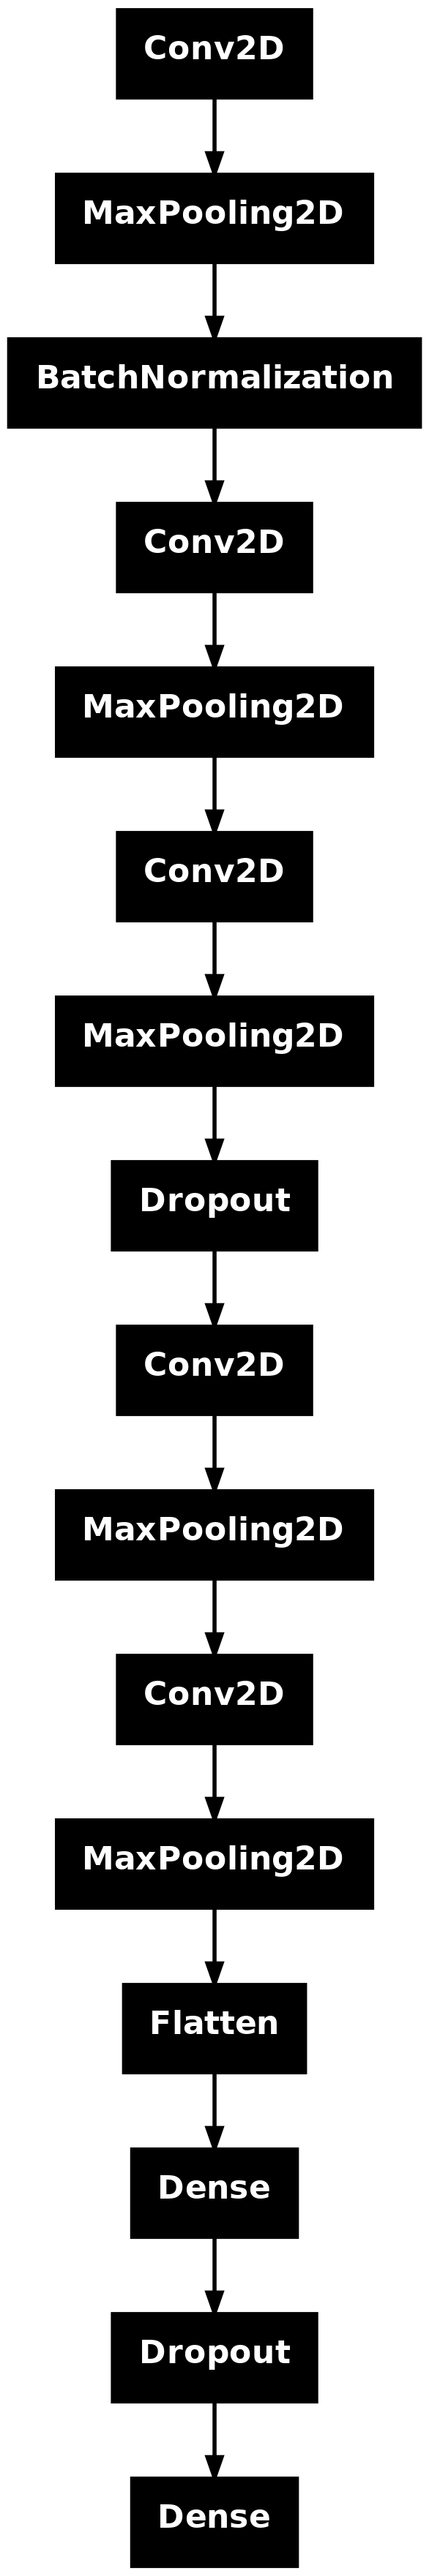

In [40]:
tf.keras.utils.plot_model(model_CNN3)

In [25]:
optimizer = Adam(learning_rate=1e-3)
model_CNN3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN3, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.4928 - loss: 7.3194 - val_accuracy: 0.5041 - val_loss: 1.6522 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5081 - loss: 1.3682 - val_accuracy: 0.5041 - val_loss: 0.9493 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5123 - loss: 0.8900 - val_accuracy: 0.5041 - val_loss: 0.7949 - learning_rate: 0.0010
Epoch 4/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5191 - loss: 0.7791

2025-02-25 10:46:06.734787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:46:06.734830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5164 - loss: 0.7768 - val_accuracy: 0.5041 - val_loss: 0.7432 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5138 - loss: 0.7352 - val_accuracy: 0.5041 - val_loss: 0.7204 - learning_rate: 0.0010
Epoch 6/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5115 - loss: 0.7170

2025-02-25 10:46:18.563164: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:46:18.563193: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5105 - loss: 0.7165 - val_accuracy: 0.5041 - val_loss: 0.7087 - learning_rate: 0.0010
Epoch 7/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5070 - loss: 0.7067

2025-02-25 10:46:24.392440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:46:24.392476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5062 - loss: 0.7065 - val_accuracy: 0.5041 - val_loss: 0.7023 - learning_rate: 0.0010
Epoch 8/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5093 - loss: 0.7012

2025-02-25 10:46:30.295315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:46:30.295349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5081 - loss: 0.7011 - val_accuracy: 0.5041 - val_loss: 0.6986 - learning_rate: 0.0010
Epoch 9/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5192 - loss: 0.6980

2025-02-25 10:46:36.223945: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:46:36.223984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5168 - loss: 0.6979 - val_accuracy: 0.5041 - val_loss: 0.6965 - learning_rate: 0.0010
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5143 - loss: 0.6961 - val_accuracy: 0.5041 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 11/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5063 - loss: 0.6950

2025-02-25 10:46:48.003862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:46:48.003908: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5052 - loss: 0.6949 - val_accuracy: 0.5041 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 12/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5118 - loss: 0.6943

2025-02-25 10:46:53.870067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:46:53.870110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5100 - loss: 0.6943 - val_accuracy: 0.5041 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5061 - loss: 0.6939 - val_accuracy: 0.5041 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 14/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5118 - loss: 0.6937

2025-02-25 10:47:05.586215: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:47:05.586259: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5103 - loss: 0.6937 - val_accuracy: 0.5041 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 15/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5109 - loss: 0.6932

2025-02-25 10:47:11.428500: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5098 - loss: 0.6933 - val_accuracy: 0.5041 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 16/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5100 - loss: 0.6930 - val_accuracy: 0.5041 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 17/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5105 - loss: 0.6932

2025-02-25 10:47:23.115458: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5096 - loss: 0.6933 - val_accuracy: 0.5041 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 18/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5092 - loss: 0.6933

2025-02-25 10:47:29.069003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:47:29.069048: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5088 - loss: 0.6933 - val_accuracy: 0.5041 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5109 - loss: 0.6930 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 20/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5126 - loss: 0.6931

2025-02-25 10:47:40.752242: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:47:40.752283: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5111 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 21/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5015 - loss: 0.6933

2025-02-25 10:47:46.648350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:47:46.648385: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5019 - loss: 0.6933 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 22/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5147 - loss: 0.6931

2025-02-25 10:47:52.522108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:47:52.522149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5129 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 23/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5136 - loss: 0.6930

2025-02-25 10:47:58.361391: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:47:58.361434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5120 - loss: 0.6930 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 5.0000e-04
Epoch 24/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5118 - loss: 0.6931

2025-02-25 10:48:04.148621: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5106 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 5.0000e-04
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5075 - loss: 0.6932 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 5.0000e-04
Epoch 26/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5139 - loss: 0.6930

2025-02-25 10:48:15.721850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5123 - loss: 0.6930 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 5.0000e-04
Epoch 27/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5098 - loss: 0.6932

2025-02-25 10:48:21.595644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:48:21.595682: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5089 - loss: 0.6932 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 5.0000e-04
Epoch 28/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5090 - loss: 0.6929 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 2.5000e-04
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5034 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 2.5000e-04
Epoch 30/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5078 - loss: 0.6931

2025-02-25 10:48:39.117884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:48:39.117923: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5072 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 2.5000e-04
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5097 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 2.5000e-04
Epoch 32/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5113 - loss: 0.6931

2025-02-25 10:48:50.795866: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:48:50.795909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5101 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 2.5000e-04
Epoch 33/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5101 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 1.2500e-04
Epoch 34/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5091 - loss: 0.6931

2025-02-25 10:49:02.433185: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:49:02.433229: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5083 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 1.2500e-04
Epoch 35/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5109 - loss: 0.6930

2025-02-25 10:49:08.265422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:49:08.265464: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5098 - loss: 0.6930 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 1.2500e-04
Epoch 36/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5055 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 1.2500e-04
Epoch 37/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5087 - loss: 0.6930

2025-02-25 10:49:20.012503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:49:20.012553: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 1.2500e-04
Epoch 38/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5068 - loss: 0.6930

2025-02-25 10:49:25.841729: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:49:25.841764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5064 - loss: 0.6930 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 6.2500e-05
Epoch 39/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5148 - loss: 0.6930

2025-02-25 10:49:31.693251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:49:31.693282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5130 - loss: 0.6930 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 6.2500e-05
Epoch 40/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5137 - loss: 0.6930

2025-02-25 10:49:37.532377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 10:49:37.532419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5121 - loss: 0.6930 - val_accuracy: 0.5041 - val_loss: 0.6931 - learning_rate: 6.2500e-05


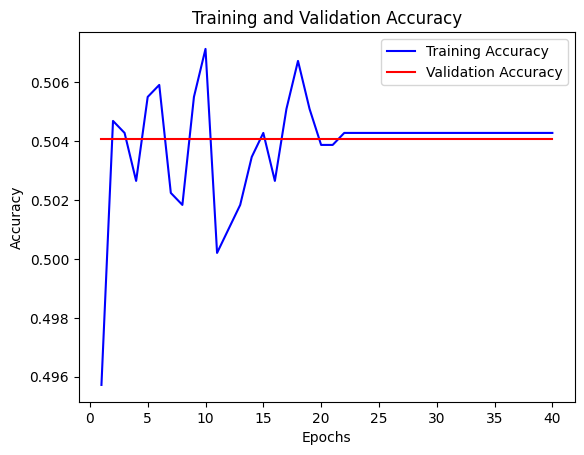

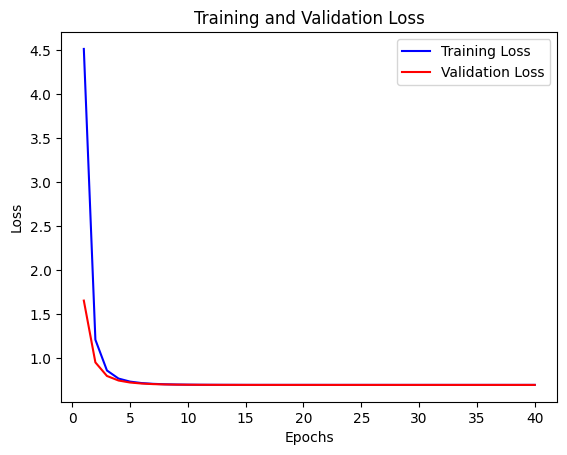

In [27]:
plot_training_history(history)

------------

### **Pretrained network VGG16**

In [3]:
conv_base_VGG16 = VGG16(weights='imagenet', #Charging the pre-trined weights of VGG16 models with  ImageNet dataset
                  include_top=False, #This option indicates that the last layers (fully connected layers) used for final classification don't be imported
                  input_shape=(224, 224, 3)) #This CNN is optimized with a 224x224 resolution

conv_base_VGG16.trainable = False #freezing layers

conv_base_VGG16.summary()

I0000 00:00:1740727808.431607  169770 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

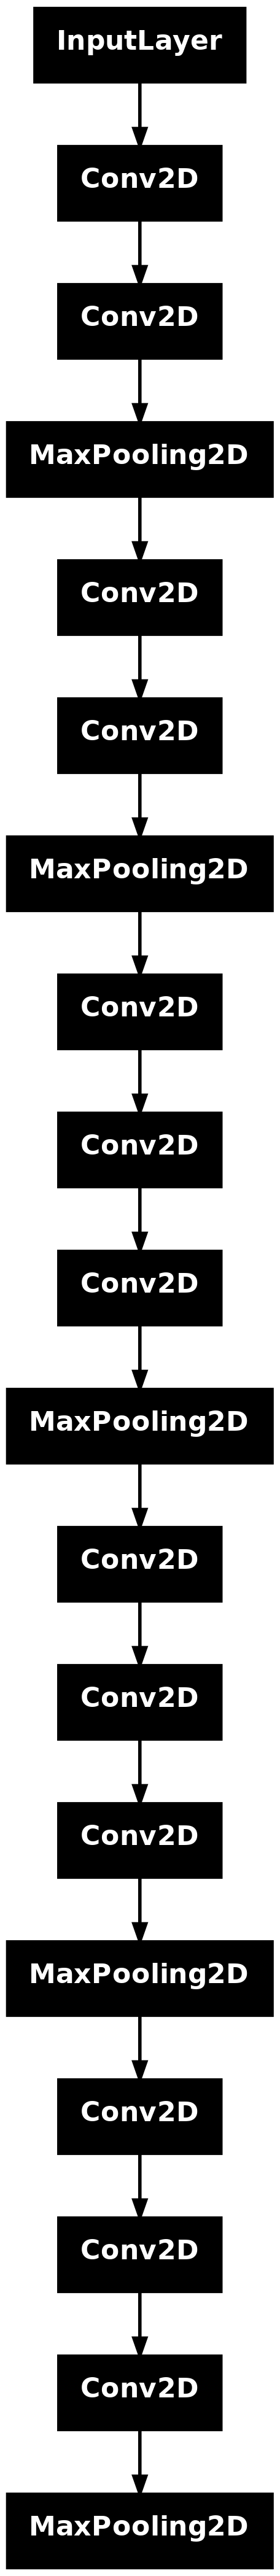

In [6]:
tf.keras.utils.plot_model(conv_base_VGG16)

### *Loading and preprocessing images*

In [4]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size = (224, 224))
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size = (224, 224))
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size = (224, 224))
class_names = train_ds.class_names

Found 2455 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [5]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)
'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(224, 224)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

### *Model 1*

In [31]:
model_VGG16_1 = models.Sequential()

# Add pretrained network
model_VGG16_1.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_1.add(layers.Flatten())  # Flatten extracted features
model_VGG16_1.add(layers.Dense(256, activation='relu'))  # Full-connected layer
model_VGG16_1.add(layers.Dropout(0.5))  #To avoid over-fitting
model_VGG16_1.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

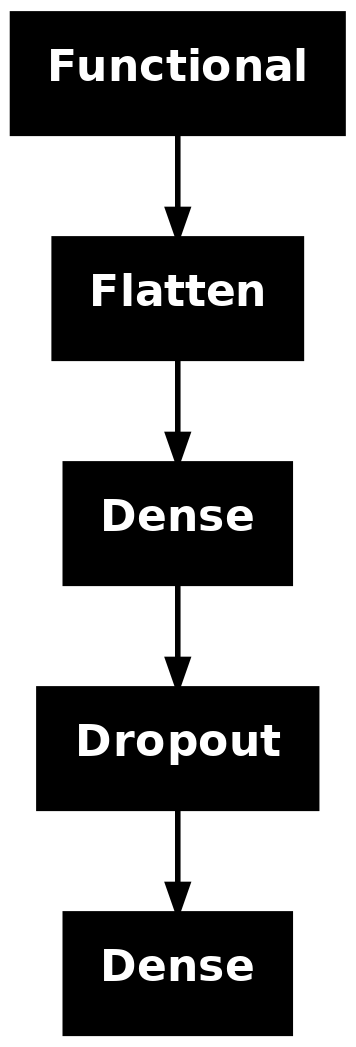

In [6]:
tf.keras.utils.plot_model(model_VGG16_1)

In [32]:
model_VGG16_1.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = train_model(model_VGG16_1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2025-02-25 11:15:15.979739: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 11:15:16.114539: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

122/150 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5306 - loss: 1.2505

2025-02-25 11:15:37.696988: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 11:15:37.765056: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

123/150 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.5307 - loss: 1.2477

2025-02-25 11:15:43.375521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:15:43.375575: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.5331 - loss: 1.1854 - val_accuracy: 0.5902 - val_loss: 0.6706 - learning_rate: 0.0010
Epoch 2/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5841 - loss: 0.6690

2025-02-25 11:16:02.852189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:16:02.852243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.5854 - loss: 0.6681 - val_accuracy: 0.6049 - val_loss: 0.6528 - learning_rate: 0.0010
Epoch 3/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5765 - loss: 0.6503

2025-02-25 11:16:21.148102: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:16:21.148133: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.5806 - loss: 0.6482 - val_accuracy: 0.6130 - val_loss: 0.6409 - learning_rate: 0.0010
Epoch 4/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6242 - loss: 0.6376

2025-02-25 11:16:39.586773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:16:39.586810: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.6244 - loss: 0.6365 - val_accuracy: 0.6439 - val_loss: 0.6217 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.6707 - loss: 0.5894 - val_accuracy: 0.6748 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 6/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6782 - loss: 0.5688

2025-02-25 11:17:16.597667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:17:16.597706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.6782 - loss: 0.5687 - val_accuracy: 0.6455 - val_loss: 0.5922 - learning_rate: 0.0010
Epoch 7/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7093 - loss: 0.5343

2025-02-25 11:17:35.185680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:17:35.185722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.7097 - loss: 0.5327 - val_accuracy: 0.6894 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 8/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7061 - loss: 0.5382

2025-02-25 11:17:53.628285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:17:53.628327: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.7087 - loss: 0.5334 - val_accuracy: 0.6829 - val_loss: 0.5601 - learning_rate: 0.0010
Epoch 9/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7035 - loss: 0.5208

2025-02-25 11:18:12.346292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:18:12.346357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.6926 - loss: 0.5256 - val_accuracy: 0.7008 - val_loss: 0.5481 - learning_rate: 0.0010
Epoch 10/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7141 - loss: 0.4885

2025-02-25 11:18:30.862070: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:18:30.862109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7158 - loss: 0.4871 - val_accuracy: 0.7317 - val_loss: 0.5339 - learning_rate: 0.0010
Epoch 11/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7378 - loss: 0.4827

2025-02-25 11:18:49.554350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:18:49.554397: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7375 - loss: 0.4808 - val_accuracy: 0.6862 - val_loss: 0.5448 - learning_rate: 0.0010
Epoch 12/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7513 - loss: 0.4788

2025-02-25 11:19:08.095875: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:19:08.095915: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.7496 - loss: 0.4781 - val_accuracy: 0.6927 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 13/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7128 - loss: 0.4988

2025-02-25 11:19:26.701720: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:19:26.701760: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.7123 - loss: 0.4972 - val_accuracy: 0.6813 - val_loss: 0.5484 - learning_rate: 0.0010
Epoch 14/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7379 - loss: 0.4481

2025-02-25 11:19:47.308647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:19:47.308689: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.7376 - loss: 0.4474 - val_accuracy: 0.7220 - val_loss: 0.5328 - learning_rate: 0.0010
Epoch 15/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7285 - loss: 0.4634

2025-02-25 11:20:06.038670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:20:06.038715: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.7248 - loss: 0.4662 - val_accuracy: 0.7333 - val_loss: 0.5284 - learning_rate: 0.0010
Epoch 16/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6964 - loss: 0.4504

2025-02-25 11:20:24.673499: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:20:24.673537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.6983 - loss: 0.4512 - val_accuracy: 0.7203 - val_loss: 0.5219 - learning_rate: 0.0010
Epoch 17/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7524 - loss: 0.4613

2025-02-25 11:20:43.450200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:20:43.450235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7531 - loss: 0.4595 - val_accuracy: 0.7382 - val_loss: 0.5118 - learning_rate: 0.0010
Epoch 18/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7660 - loss: 0.4289

2025-02-25 11:21:02.141235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7688 - loss: 0.4263 - val_accuracy: 0.7187 - val_loss: 0.5289 - learning_rate: 0.0010
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7937 - loss: 0.4157 - val_accuracy: 0.6780 - val_loss: 0.5736 - learning_rate: 0.0010
Epoch 20/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7661 - loss: 0.4270

2025-02-25 11:21:39.494975: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:21:39.495017: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7697 - loss: 0.4221 - val_accuracy: 0.7366 - val_loss: 0.5289 - learning_rate: 0.0010
Epoch 21/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8021 - loss: 0.3826

2025-02-25 11:21:58.185462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:21:58.185506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.8015 - loss: 0.3838 - val_accuracy: 0.7041 - val_loss: 0.6226 - learning_rate: 0.0010
Epoch 22/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7920 - loss: 0.3977

2025-02-25 11:22:16.777717: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:22:16.777753: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7937 - loss: 0.3942 - val_accuracy: 0.7480 - val_loss: 0.5929 - learning_rate: 0.0010
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.7776 - loss: 0.3799 - val_accuracy: 0.7252 - val_loss: 0.5046 - learning_rate: 0.0010
Epoch 24/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7398 - loss: 0.4297

2025-02-25 11:22:54.394091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:22:54.394134: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.7461 - loss: 0.4248 - val_accuracy: 0.7089 - val_loss: 0.5731 - learning_rate: 0.0010
Epoch 25/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8082 - loss: 0.4409

2025-02-25 11:23:13.252137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:23:13.252176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8099 - loss: 0.4359 - val_accuracy: 0.7480 - val_loss: 0.5434 - learning_rate: 0.0010
Epoch 26/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8450 - loss: 0.3291

2025-02-25 11:23:32.031466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:23:32.031509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8440 - loss: 0.3292 - val_accuracy: 0.7431 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 27/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8333 - loss: 0.3260

2025-02-25 11:23:52.565848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:23:52.565884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.8333 - loss: 0.3263 - val_accuracy: 0.7480 - val_loss: 0.6557 - learning_rate: 0.0010
Epoch 28/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8333 - loss: 0.3375

2025-02-25 11:24:11.318652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:24:11.318688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.8344 - loss: 0.3356 - val_accuracy: 0.7512 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 29/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.8459 - loss: 0.3267

2025-02-25 11:24:30.162880: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:24:30.162916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8446 - loss: 0.3277 - val_accuracy: 0.7431 - val_loss: 0.5390 - learning_rate: 0.0010
Epoch 30/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8437 - loss: 0.3238

2025-02-25 11:24:49.013078: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8409 - loss: 0.3249 - val_accuracy: 0.7366 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8230 - loss: 0.3196 - val_accuracy: 0.7220 - val_loss: 0.5313 - learning_rate: 0.0010
Epoch 32/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8135 - loss: 0.3332

2025-02-25 11:25:26.782529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:25:26.782567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8128 - loss: 0.3340 - val_accuracy: 0.7301 - val_loss: 0.6609 - learning_rate: 0.0010
Epoch 33/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8326 - loss: 0.3165

2025-02-25 11:25:45.585448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:25:45.585488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8314 - loss: 0.3175 - val_accuracy: 0.7528 - val_loss: 0.5741 - learning_rate: 0.0010


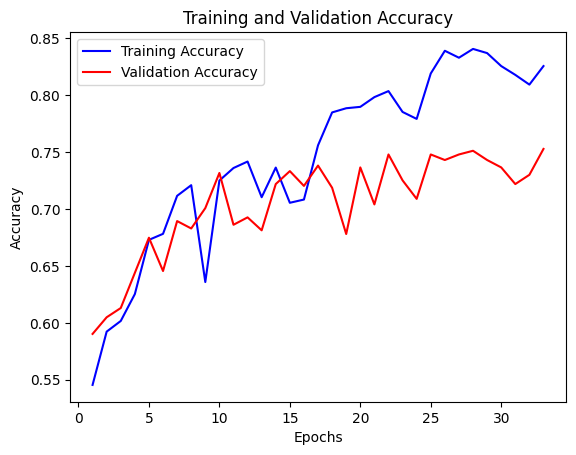

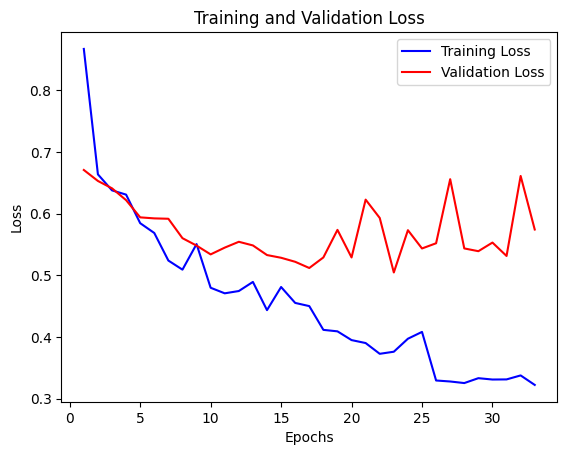

In [34]:
plot_training_history(history)

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

2025-02-25 11:27:12.680718: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 11:27:12.757123: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step
Accuracy on test dataset: 0.4902

Classification Report:
               precision    recall  f1-score   support

    fracture       0.50      0.56      0.53       387
  nofracture       0.48      0.42      0.45       380

    accuracy                           0.49       767
   macro avg       0.49      0.49      0.49       767
weighted avg       0.49      0.49      0.49       767



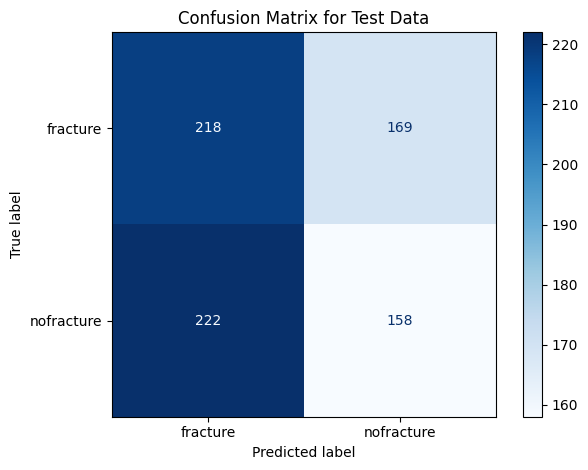

In [35]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step
AUC: 0.4892


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


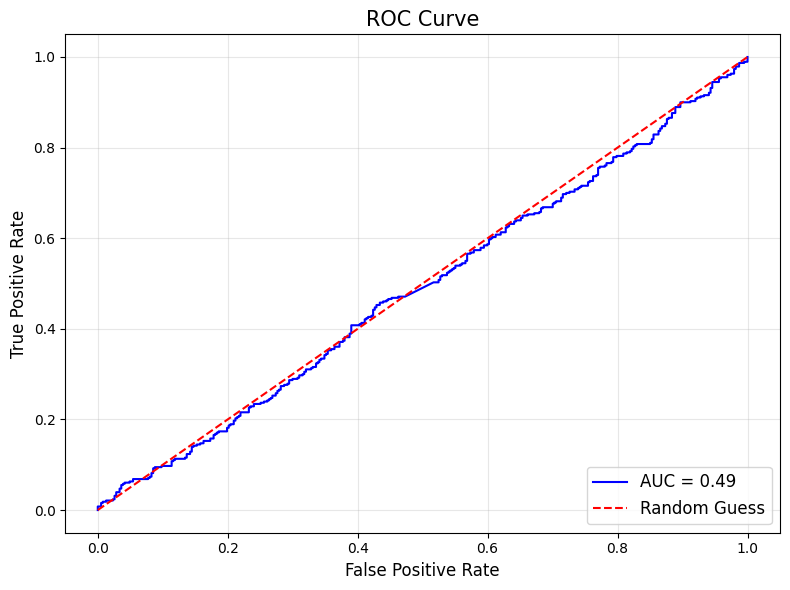

In [36]:
auc = plot_auc_curve(model_VGG16_1, test_ds)

---------------------

## *Model 2*

In [37]:
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True

In [38]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

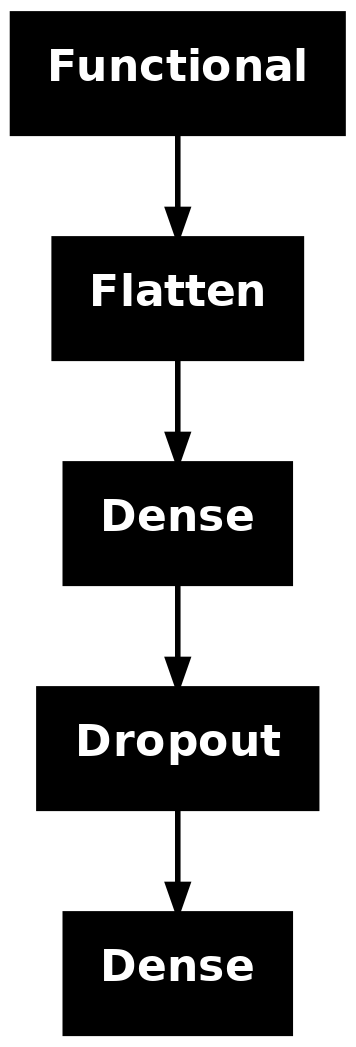

In [26]:
tf.keras.utils.plot_model(model_VGG16_2)

In [39]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_VGG16_2, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2025-02-25 11:28:02.983488: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,28,28]{3,2,1,0}, f32[512,256,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 11:28:03.385585: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,512,28,28]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

122/150 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.5576 - loss: 5.5853

2025-02-25 11:28:35.291684: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,256,28,28]{3,2,1,0}, f32[512,256,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 11:28:35.655673: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,512,28,28]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

123/150 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.5577 - loss: 5.5836

2025-02-25 11:28:40.251136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:28:40.251180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.5613 - loss: 5.5469 - val_accuracy: 0.6016 - val_loss: 4.9755 - learning_rate: 1.0000e-05
Epoch 2/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.6876 - loss: 4.7513

2025-02-25 11:29:11.607526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:29:11.607562: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 201ms/step - accuracy: 0.6917 - loss: 4.7236 - val_accuracy: 0.7106 - val_loss: 4.3204 - learning_rate: 1.0000e-05
Epoch 3/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.7673 - loss: 4.1321

2025-02-25 11:29:41.987157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:29:41.987185: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.7733 - loss: 4.1048 - val_accuracy: 0.7187 - val_loss: 3.9123 - learning_rate: 1.0000e-05
Epoch 4/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.8285 - loss: 3.6408

2025-02-25 11:30:12.407380: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:30:12.407415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.8330 - loss: 3.6193 - val_accuracy: 0.7675 - val_loss: 3.5087 - learning_rate: 1.0000e-05
Epoch 5/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.8805 - loss: 3.2394

2025-02-25 11:30:42.866245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:30:42.866282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.8841 - loss: 3.2222 - val_accuracy: 0.7886 - val_loss: 3.2422 - learning_rate: 1.0000e-05
Epoch 6/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9282 - loss: 2.9012

2025-02-25 11:31:13.459228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:31:13.459257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.9295 - loss: 2.8898 - val_accuracy: 0.7935 - val_loss: 3.0321 - learning_rate: 1.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 213ms/step - accuracy: 0.9536 - loss: 2.6629 - val_accuracy: 0.8163 - val_loss: 2.8505 - learning_rate: 1.0000e-05
Epoch 8/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9706 - loss: 2.4617

2025-02-25 11:32:15.927424: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:32:15.927463: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9718 - loss: 2.4520 - val_accuracy: 0.8244 - val_loss: 2.7326 - learning_rate: 1.0000e-05
Epoch 9/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9827 - loss: 2.2903

2025-02-25 11:32:46.512537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:32:46.512568: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9830 - loss: 2.2837 - val_accuracy: 0.8325 - val_loss: 2.6042 - learning_rate: 1.0000e-05
Epoch 10/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9894 - loss: 2.1449

2025-02-25 11:33:17.343683: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:33:17.343736: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9895 - loss: 2.1391 - val_accuracy: 0.8374 - val_loss: 2.4991 - learning_rate: 1.0000e-05
Epoch 11/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9911 - loss: 2.0270

2025-02-25 11:33:47.927857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:33:47.927895: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9913 - loss: 2.0218 - val_accuracy: 0.8341 - val_loss: 2.4406 - learning_rate: 1.0000e-05
Epoch 12/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9960 - loss: 1.9161

2025-02-25 11:34:18.574680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:34:18.574713: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9959 - loss: 1.9123 - val_accuracy: 0.8146 - val_loss: 2.4063 - learning_rate: 1.0000e-05
Epoch 13/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9958 - loss: 1.8260

2025-02-25 11:34:49.287808: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:34:49.287855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9951 - loss: 1.8239 - val_accuracy: 0.8081 - val_loss: 2.3193 - learning_rate: 1.0000e-05
Epoch 14/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9756 - loss: 1.8017

2025-02-25 11:35:19.913761: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-25 11:35:19.913791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:35:19.913806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9778 - loss: 1.7930 - val_accuracy: 0.8293 - val_loss: 2.2021 - learning_rate: 1.0000e-05
Epoch 15/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9950 - loss: 1.6720

2025-02-25 11:35:50.646573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:35:50.646609: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9948 - loss: 1.6692 - val_accuracy: 0.8293 - val_loss: 2.1491 - learning_rate: 1.0000e-05
Epoch 16/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9942 - loss: 1.6095

2025-02-25 11:36:21.336059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:36:21.336096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9946 - loss: 1.6061 - val_accuracy: 0.8423 - val_loss: 2.1054 - learning_rate: 1.0000e-05
Epoch 17/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9967 - loss: 1.5427

2025-02-25 11:36:52.107752: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:36:52.107786: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9969 - loss: 1.5393 - val_accuracy: 0.8325 - val_loss: 2.0810 - learning_rate: 1.0000e-05
Epoch 18/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9954 - loss: 1.4872

2025-02-25 11:37:22.965735: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:37:22.965774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9951 - loss: 1.4858 - val_accuracy: 0.8260 - val_loss: 1.9827 - learning_rate: 1.0000e-05
Epoch 19/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9965 - loss: 1.4310

2025-02-25 11:37:53.681227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:37:53.681269: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9968 - loss: 1.4275 - val_accuracy: 0.8455 - val_loss: 1.9111 - learning_rate: 1.0000e-05
Epoch 20/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9972 - loss: 1.3742

2025-02-25 11:38:34.511364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:38:34.511401: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - accuracy: 0.9974 - loss: 1.3711 - val_accuracy: 0.8374 - val_loss: 1.8900 - learning_rate: 1.0000e-05
Epoch 21/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9984 - loss: 1.3128

2025-02-25 11:39:06.595544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:39:06.595585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9986 - loss: 1.3103 - val_accuracy: 0.8520 - val_loss: 1.8851 - learning_rate: 1.0000e-05
Epoch 22/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9985 - loss: 1.2629

2025-02-25 11:39:37.414944: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:39:37.414979: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9986 - loss: 1.2602 - val_accuracy: 0.8439 - val_loss: 1.8475 - learning_rate: 1.0000e-05
Epoch 23/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9986 - loss: 1.2109

2025-02-25 11:40:08.179785: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:40:08.179827: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9987 - loss: 1.2084 - val_accuracy: 0.8439 - val_loss: 1.8125 - learning_rate: 1.0000e-05
Epoch 24/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9984 - loss: 1.1599

2025-02-25 11:40:38.932438: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:40:38.932477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9985 - loss: 1.1574 - val_accuracy: 0.8407 - val_loss: 1.7188 - learning_rate: 1.0000e-05
Epoch 25/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9985 - loss: 1.1144

2025-02-25 11:41:09.708246: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:41:09.708292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9986 - loss: 1.1117 - val_accuracy: 0.8325 - val_loss: 1.6993 - learning_rate: 1.0000e-05
Epoch 26/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9985 - loss: 1.0642

2025-02-25 11:41:50.621608: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:41:50.621648: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.9987 - loss: 1.0618 - val_accuracy: 0.8439 - val_loss: 1.6239 - learning_rate: 1.0000e-05
Epoch 27/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 1.0000 - loss: 1.0096

2025-02-25 11:42:21.298575: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:42:21.298612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 1.0000 - loss: 1.0074 - val_accuracy: 0.8569 - val_loss: 1.5804 - learning_rate: 1.0000e-05
Epoch 28/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9988 - loss: 0.9655

2025-02-25 11:42:52.057647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:42:52.057684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9988 - loss: 0.9632 - val_accuracy: 0.8407 - val_loss: 1.5674 - learning_rate: 1.0000e-05
Epoch 29/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9982 - loss: 0.9204

2025-02-25 11:43:22.784528: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:43:22.784562: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9979 - loss: 0.9192 - val_accuracy: 0.8276 - val_loss: 1.4531 - learning_rate: 1.0000e-05
Epoch 30/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9794 - loss: 0.9404

2025-02-25 11:43:53.584324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:43:53.584354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9795 - loss: 0.9379 - val_accuracy: 0.7967 - val_loss: 1.5464 - learning_rate: 1.0000e-05
Epoch 31/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9906 - loss: 0.8685

2025-02-25 11:44:24.430097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:44:24.430144: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9910 - loss: 0.8662 - val_accuracy: 0.8358 - val_loss: 1.4792 - learning_rate: 1.0000e-05
Epoch 32/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9935 - loss: 0.8322

2025-02-25 11:44:55.113287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:44:55.113325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9940 - loss: 0.8301 - val_accuracy: 0.8309 - val_loss: 1.4146 - learning_rate: 1.0000e-05
Epoch 33/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9987 - loss: 0.7900

2025-02-25 11:45:25.854541: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:45:25.854586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9988 - loss: 0.7883 - val_accuracy: 0.8504 - val_loss: 1.3784 - learning_rate: 1.0000e-05
Epoch 34/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9983 - loss: 0.7588

2025-02-25 11:45:56.605002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:45:56.605034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9984 - loss: 0.7573 - val_accuracy: 0.8488 - val_loss: 1.3671 - learning_rate: 1.0000e-05
Epoch 35/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9983 - loss: 0.7278

2025-02-25 11:46:27.381091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:46:27.381132: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9985 - loss: 0.7264 - val_accuracy: 0.8520 - val_loss: 1.3504 - learning_rate: 1.0000e-05
Epoch 36/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9989 - loss: 0.6977

2025-02-25 11:46:58.134294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:46:58.134333: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9990 - loss: 0.6964 - val_accuracy: 0.8520 - val_loss: 1.3329 - learning_rate: 1.0000e-05
Epoch 37/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9984 - loss: 0.6724

2025-02-25 11:47:29.032130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:47:29.032168: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9985 - loss: 0.6708 - val_accuracy: 0.8520 - val_loss: 1.2937 - learning_rate: 1.0000e-05
Epoch 38/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9982 - loss: 0.6425

2025-02-25 11:47:59.706627: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:47:59.706656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9984 - loss: 0.6410 - val_accuracy: 0.8472 - val_loss: 1.2756 - learning_rate: 1.0000e-05
Epoch 39/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 1.0000 - loss: 0.6113

2025-02-25 11:48:30.442092: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:48:30.442133: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 1.0000 - loss: 0.6099 - val_accuracy: 0.8504 - val_loss: 1.2777 - learning_rate: 1.0000e-05
Epoch 40/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9984 - loss: 0.5860

2025-02-25 11:49:01.284835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:49:01.284877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9985 - loss: 0.5845 - val_accuracy: 0.8439 - val_loss: 1.2310 - learning_rate: 1.0000e-05
Epoch 41/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9852 - loss: 0.5937

2025-02-25 11:49:32.005393: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:49:32.005434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9840 - loss: 0.5973 - val_accuracy: 0.8179 - val_loss: 1.1486 - learning_rate: 1.0000e-05
Epoch 42/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9840 - loss: 0.5882

2025-02-25 11:50:02.982566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:50:02.982598: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9851 - loss: 0.5847 - val_accuracy: 0.8374 - val_loss: 1.1566 - learning_rate: 1.0000e-05
Epoch 43/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9934 - loss: 0.5430

2025-02-25 11:50:33.535801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:50:33.535835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9936 - loss: 0.5420 - val_accuracy: 0.8358 - val_loss: 1.1266 - learning_rate: 1.0000e-05
Epoch 44/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9991 - loss: 0.5096

2025-02-25 11:51:04.353176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:51:04.353211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9991 - loss: 0.5087 - val_accuracy: 0.8423 - val_loss: 1.1588 - learning_rate: 1.0000e-05
Epoch 45/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9989 - loss: 0.4901

2025-02-25 11:51:45.199779: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:51:45.199809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.9989 - loss: 0.4893 - val_accuracy: 0.8488 - val_loss: 1.1370 - learning_rate: 1.0000e-05
Epoch 46/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9983 - loss: 0.4731

2025-02-25 11:52:15.975085: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:52:15.975127: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9984 - loss: 0.4722 - val_accuracy: 0.8472 - val_loss: 1.1337 - learning_rate: 1.0000e-05


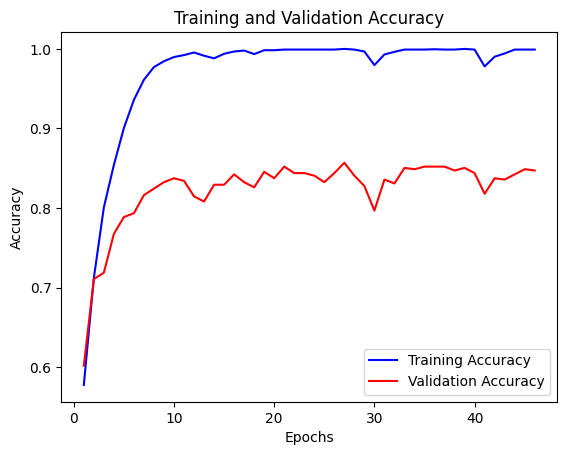

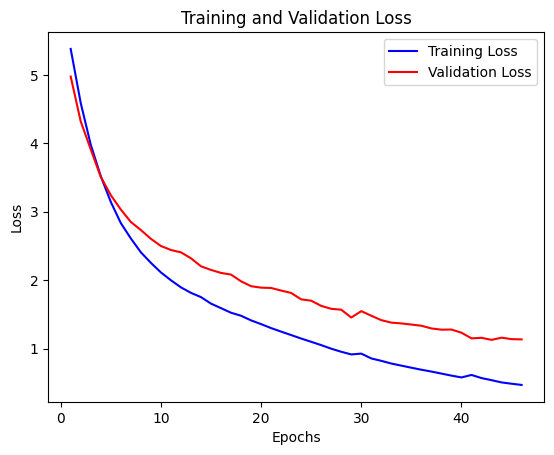

In [41]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step
Accuracy on test dataset: 0.5085

Classification Report:
               precision    recall  f1-score   support

    fracture       0.51      0.50      0.51       387
  nofracture       0.50      0.52      0.51       380

    accuracy                           0.51       767
   macro avg       0.51      0.51      0.51       767
weighted avg       0.51      0.51      0.51       767



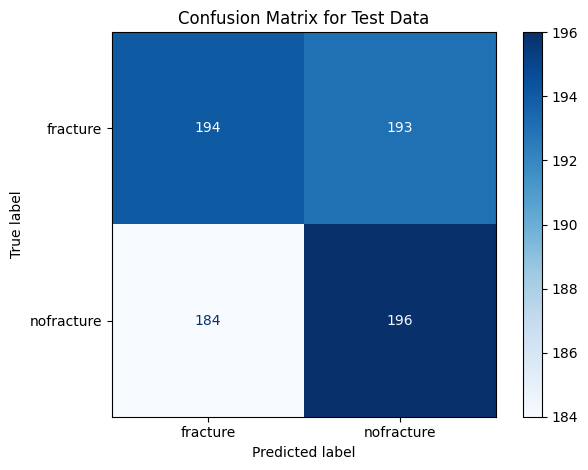

In [42]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_2, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step
AUC: 0.4559


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


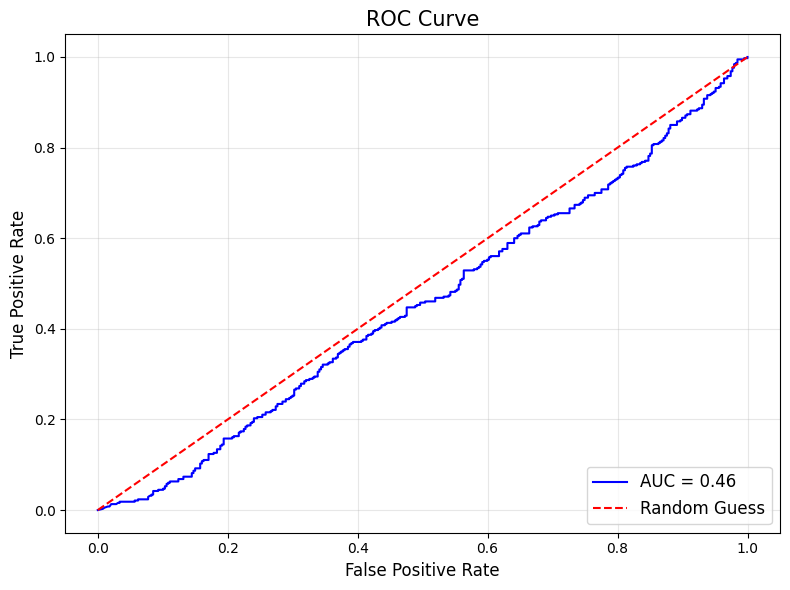

In [43]:
auc = plot_auc_curve(model_VGG16_2, test_ds)

------------------------------

**Model 2.1**

In [44]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [45]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_VGG16_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.7182 - loss: 5.5371

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - accuracy: 0.7236 - loss: 5.5241 - val_accuracy: 0.8146 - val_loss: 5.2505 - learning_rate: 1.0000e-05
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 234ms/step - accuracy: 0.9554 - loss: 4.8562 - val_accuracy: 0.8423 - val_loss: 4.9879 - learning_rate: 1.0000e-05
Epoch 3/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.9824 - loss: 4.5403

2025-02-25 11:55:23.552740: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:55:23.552797: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.9825 - loss: 4.5367 - val_accuracy: 0.8211 - val_loss: 4.8235 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.9922 - loss: 4.2659 - val_accuracy: 0.8341 - val_loss: 4.5476 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.9924 - loss: 4.0296 - val_accuracy: 0.8439 - val_loss: 4.3690 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9959 - loss: 3.8068 - val_accuracy: 0.8520 - val_loss: 4.1419 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9959 - loss: 3.5977 - val_accuracy: 0.8520 - val_loss: 4.0051 - learning_rate: 1.0000e-05
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9993 - loss: 3.3965 - val_accuracy: 0.8341 - val_loss: 3.9617 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/s

2025-02-25 11:59:08.607717: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 11:59:08.607748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9978 - loss: 3.0468 - val_accuracy: 0.8520 - val_loss: 3.5257 - learning_rate: 1.0000e-05
Epoch 11/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.9970 - loss: 2.8858

2025-02-25 11:59:39.465026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9970 - loss: 2.8837 - val_accuracy: 0.8341 - val_loss: 3.3962 - learning_rate: 1.0000e-05
Epoch 12/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.9875 - loss: 2.7511

2025-02-25 12:00:20.242059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:00:20.242088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9875 - loss: 2.7494 - val_accuracy: 0.7740 - val_loss: 3.6146 - learning_rate: 1.0000e-05
Epoch 13/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.9816 - loss: 2.6525

2025-02-25 12:00:51.015672: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:00:51.015708: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9820 - loss: 2.6495 - val_accuracy: 0.8423 - val_loss: 3.1143 - learning_rate: 1.0000e-05
Epoch 14/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.9999 - loss: 2.4747

2025-02-25 12:01:21.829068: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9999 - loss: 2.4730 - val_accuracy: 0.8520 - val_loss: 3.0072 - learning_rate: 1.0000e-05
Epoch 15/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9966 - loss: 2.3602 - val_accuracy: 0.8537 - val_loss: 2.8883 - learning_rate: 1.0000e-05
Epoch 16/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9985 - loss: 2.2440 - val_accuracy: 0.8569 - val_loss: 2.8115 - learning_rate: 1.0000e-05
Epoch 17/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9992 - loss: 2.1342 - val_accuracy: 0.8520 - val_loss: 2.7299 - learning_rate: 1.0000e-05
Epoch 18/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 1.0000 - loss: 2.0289

2025-02-25 12:03:25.009104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:03:25.009141: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 1.0000 - loss: 2.0275 - val_accuracy: 0.8618 - val_loss: 2.6297 - learning_rate: 1.0000e-05
Epoch 19/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9983 - loss: 1.9276 - val_accuracy: 0.8602 - val_loss: 2.4981 - learning_rate: 1.0000e-05
Epoch 20/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.9986 - loss: 1.8301

2025-02-25 12:04:36.667471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:04:36.667505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9986 - loss: 1.8287 - val_accuracy: 0.8585 - val_loss: 2.4131 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9985 - loss: 1.7306 - val_accuracy: 0.8569 - val_loss: 2.3342 - learning_rate: 1.0000e-05
Epoch 22/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.9984 - loss: 1.6383

2025-02-25 12:05:38.396739: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9984 - loss: 1.6370 - val_accuracy: 0.8537 - val_loss: 2.2486 - learning_rate: 1.0000e-05
Epoch 23/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.9990 - loss: 1.5438 - val_accuracy: 0.8667 - val_loss: 2.1417 - learning_rate: 1.0000e-05
Epoch 24/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9983 - loss: 1.4563 - val_accuracy: 0.8585 - val_loss: 2.1091 - learning_rate: 1.0000e-05
Epoch 25/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9994 - loss: 1.3691 - val_accuracy: 0.8553 - val_loss: 1.9859 - learning_rate: 1.0000e-05
Epoch 26/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9985 - loss: 1.2883 - val_accuracy: 0.8520 - val_loss: 1.9193 - learning_rate: 1.0000e-05
Epoch 27/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.9985 - loss: 1.2074 - val_accuracy: 0.8553 - val_loss: 1.8338 - learning_rate: 1.0000e-05
Epoch 28/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 22

2025-02-25 12:08:53.568159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9986 - loss: 1.1296 - val_accuracy: 0.8537 - val_loss: 1.7740 - learning_rate: 1.0000e-05
Epoch 29/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9976 - loss: 1.0616 - val_accuracy: 0.8228 - val_loss: 1.5005 - learning_rate: 1.0000e-05
Epoch 30/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9571 - loss: 1.0958 - val_accuracy: 0.8146 - val_loss: 1.6118 - learning_rate: 1.0000e-05
Epoch 31/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9896 - loss: 0.9942 - val_accuracy: 0.8488 - val_loss: 1.5149 - learning_rate: 1.0000e-05
Epoch 32/100
123/130 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.9987 - loss: 0.9250

2025-02-25 12:10:56.954331: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:10:56.954378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9987 - loss: 0.9245 - val_accuracy: 0.8504 - val_loss: 1.5076 - learning_rate: 1.0000e-05


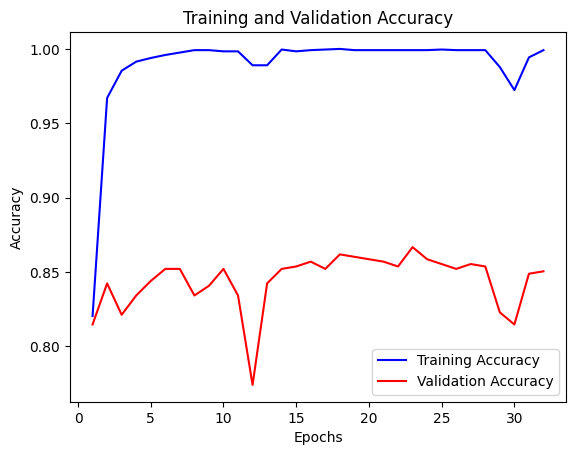

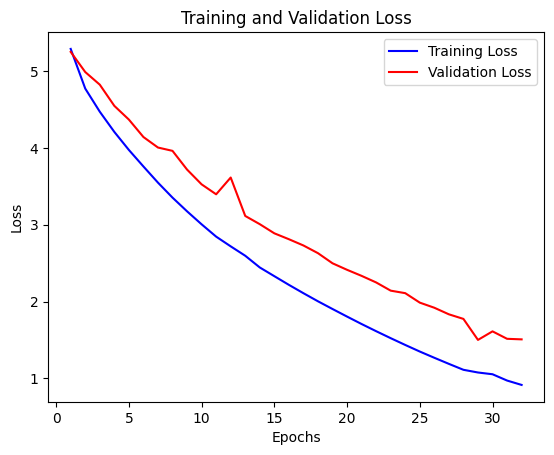

In [47]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step
Accuracy on test dataset: 0.4772

Classification Report:
               precision    recall  f1-score   support

    fracture       0.48      0.44      0.46       387
  nofracture       0.47      0.52      0.49       380

    accuracy                           0.48       767
   macro avg       0.48      0.48      0.48       767
weighted avg       0.48      0.48      0.48       767



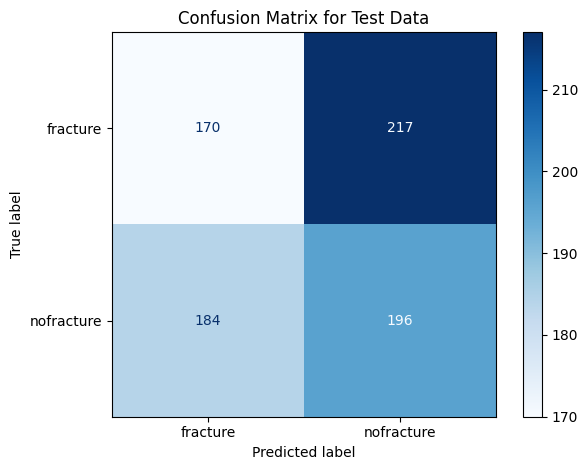

In [48]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_2, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step


AUC: 0.4894


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


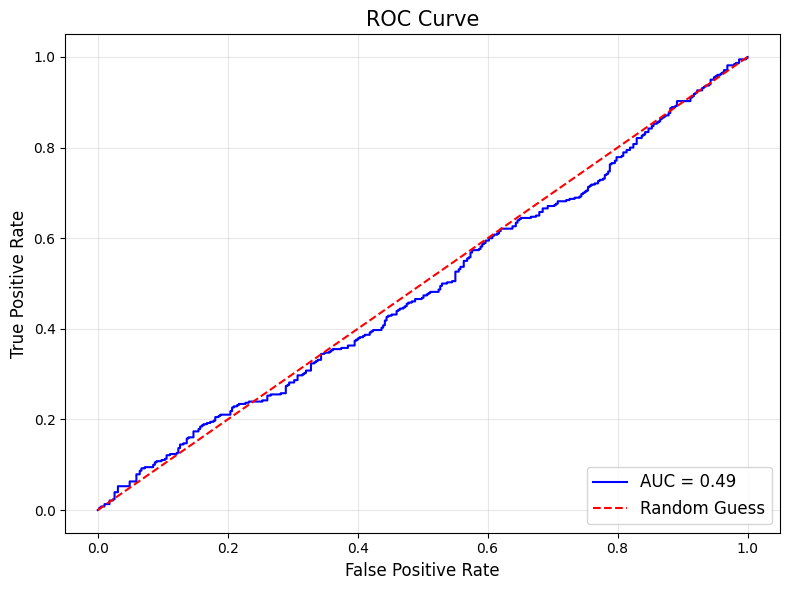

In [49]:
auc = plot_auc_curve(model_VGG16_2, test_ds)

------------

**Model 2.2**

In [50]:
#Unfreezing the lats 12 layers
for layer in conv_base_VGG16.layers[-12:]:
    layer.trainable = True

In [51]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 20,877,569 (79.64 MB)

 Non-trainable params: 260,160 (1016.25 KB)

In [52]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_VGG16_2, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2025-02-25 12:26:13.257346: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,128,56,56]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 12:26:13.719953: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,56,56]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

122/150 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.7323 - loss: 5.5028

2025-02-25 12:26:52.749049: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,256,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,128,56,56]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 12:26:53.174665: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,256,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,256,56,56]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

123/150 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.7331 - loss: 5.5007

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 291ms/step - accuracy: 0.7518 - loss: 5.4546 - val_accuracy: 0.8114 - val_loss: 5.2642 - learning_rate: 1.0000e-05
Epoch 2/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.9543 - loss: 4.8216

2025-02-25 12:27:36.126346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:27:36.126390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 248ms/step - accuracy: 0.9571 - loss: 4.8047 - val_accuracy: 0.8325 - val_loss: 5.0767 - learning_rate: 1.0000e-05
Epoch 3/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.9885 - loss: 4.4870

2025-02-25 12:28:13.710723: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:28:13.710763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 250ms/step - accuracy: 0.9890 - loss: 4.4746 - val_accuracy: 0.8472 - val_loss: 4.8792 - learning_rate: 1.0000e-05
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 250ms/step - accuracy: 0.9770 - loss: 4.2626 - val_accuracy: 0.8488 - val_loss: 4.6138 - learning_rate: 1.0000e-05
Epoch 5/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.9978 - loss: 3.9910

2025-02-25 12:29:28.933746: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:29:28.933775: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.9978 - loss: 3.9804 - val_accuracy: 0.8585 - val_loss: 4.4055 - learning_rate: 1.0000e-05
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.9975 - loss: 3.7630 - val_accuracy: 0.8520 - val_loss: 4.2727 - learning_rate: 1.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 252ms/step - accuracy: 0.9965 - loss: 3.5520 - val_accuracy: 0.8504 - val_loss: 4.0999 - learning_rate: 1.0000e-05
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 252ms/step - accuracy: 0.9982 - loss: 3.3509 - val_accuracy: 0.8488 - val_loss: 3.9101 - learning_rate: 1.0000e-05
Epoch 9/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9874 - loss: 3.2038

2025-02-25 12:32:00.420460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:32:00.420489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.9880 - loss: 3.1953 - val_accuracy: 0.8634 - val_loss: 3.6062 - learning_rate: 1.0000e-05
Epoch 10/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9973 - loss: 3.0127

2025-02-25 12:32:38.423302: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:32:38.423362: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.9976 - loss: 3.0049 - val_accuracy: 0.8618 - val_loss: 3.5260 - learning_rate: 1.0000e-05
Epoch 11/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.9980 - loss: 2.8509

2025-02-25 12:33:16.460448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:33:16.460475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.9982 - loss: 2.8438 - val_accuracy: 0.8667 - val_loss: 3.4254 - learning_rate: 1.0000e-05
Epoch 12/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9991 - loss: 2.6997

2025-02-25 12:33:54.528809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:33:54.528852: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.9990 - loss: 2.6931 - val_accuracy: 0.8650 - val_loss: 3.3010 - learning_rate: 1.0000e-05
Epoch 13/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9949 - loss: 2.5661

2025-02-25 12:34:32.808525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:34:32.808556: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.9946 - loss: 2.5609 - val_accuracy: 0.8407 - val_loss: 3.2053 - learning_rate: 1.0000e-05
Epoch 14/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9929 - loss: 2.4454

2025-02-25 12:35:10.795641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:35:10.795675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.9929 - loss: 2.4404 - val_accuracy: 0.8374 - val_loss: 3.0567 - learning_rate: 1.0000e-05
Epoch 15/100
120/150 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.9975 - loss: 2.3168

2025-02-25 12:35:48.741597: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:35:48.741642: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.9975 - loss: 2.3110 - val_accuracy: 0.8455 - val_loss: 2.8947 - learning_rate: 1.0000e-05
Epoch 16/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9984 - loss: 2.1987 - val_accuracy: 0.8423 - val_loss: 2.8931 - learning_rate: 1.0000e-05
Epoch 17/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9957 - loss: 2.1027

2025-02-25 12:37:05.083874: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:37:05.083906: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9962 - loss: 2.0971 - val_accuracy: 0.8455 - val_loss: 2.8533 - learning_rate: 1.0000e-05
Epoch 18/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9944 - loss: 2.0070

2025-02-25 12:37:43.285853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:37:43.285887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9944 - loss: 2.0031 - val_accuracy: 0.8634 - val_loss: 2.5577 - learning_rate: 1.0000e-05
Epoch 19/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9991 - loss: 1.9024

2025-02-25 12:38:21.439060: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9990 - loss: 1.8983 - val_accuracy: 0.8553 - val_loss: 2.5831 - learning_rate: 1.0000e-05
Epoch 20/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9878 - loss: 1.8404

2025-02-25 12:38:59.750489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:38:59.750530: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9881 - loss: 1.8363 - val_accuracy: 0.8244 - val_loss: 2.6530 - learning_rate: 1.0000e-05
Epoch 21/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9971 - loss: 1.7371

2025-02-25 12:39:37.796287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:39:37.796336: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9974 - loss: 1.7327 - val_accuracy: 0.8553 - val_loss: 2.4624 - learning_rate: 1.0000e-05
Epoch 22/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9988 - loss: 1.6532

2025-02-25 12:40:16.164997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:40:16.165033: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9989 - loss: 1.6498 - val_accuracy: 0.8650 - val_loss: 2.3926 - learning_rate: 1.0000e-05
Epoch 23/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9985 - loss: 1.5769

2025-02-25 12:40:54.243888: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:40:54.243929: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9986 - loss: 1.5735 - val_accuracy: 0.8602 - val_loss: 2.3190 - learning_rate: 1.0000e-05
Epoch 24/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9986 - loss: 1.5013

2025-02-25 12:41:32.427301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9987 - loss: 1.4976 - val_accuracy: 0.8455 - val_loss: 2.3159 - learning_rate: 1.0000e-05
Epoch 25/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.9982 - loss: 1.4276

2025-02-25 12:42:10.614691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:42:10.614727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9984 - loss: 1.4241 - val_accuracy: 0.8553 - val_loss: 2.2086 - learning_rate: 1.0000e-05
Epoch 26/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9988 - loss: 1.3532

2025-02-25 12:42:48.980767: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:42:48.980809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.9988 - loss: 1.3500 - val_accuracy: 0.8553 - val_loss: 2.1081 - learning_rate: 1.0000e-05
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9984 - loss: 1.2792 - val_accuracy: 0.8585 - val_loss: 2.0250 - learning_rate: 1.0000e-05
Epoch 28/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9984 - loss: 1.2125

2025-02-25 12:44:05.449914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:44:05.449960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9985 - loss: 1.2094 - val_accuracy: 0.8634 - val_loss: 1.9420 - learning_rate: 1.0000e-05
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.9985 - loss: 1.1409 - val_accuracy: 0.8602 - val_loss: 1.8900 - learning_rate: 1.0000e-05
Epoch 30/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9992 - loss: 1.0768

2025-02-25 12:45:24.535388: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:45:24.535423: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9993 - loss: 1.0738 - val_accuracy: 0.8488 - val_loss: 1.8805 - learning_rate: 1.0000e-05
Epoch 31/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9995 - loss: 1.0122

2025-02-25 12:46:02.877274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9995 - loss: 1.0093 - val_accuracy: 0.8569 - val_loss: 1.7923 - learning_rate: 1.0000e-05
Epoch 32/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9986 - loss: 0.9473 - val_accuracy: 0.8585 - val_loss: 1.7132 - learning_rate: 1.0000e-05
Epoch 33/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9989 - loss: 0.8892

2025-02-25 12:47:19.139691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:47:19.139732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9990 - loss: 0.8862 - val_accuracy: 0.8618 - val_loss: 1.6587 - learning_rate: 1.0000e-05
Epoch 34/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9994 - loss: 0.8303

2025-02-25 12:47:57.371008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:47:57.371056: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9994 - loss: 0.8277 - val_accuracy: 0.8569 - val_loss: 1.5768 - learning_rate: 1.0000e-05
Epoch 35/100
122/150 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9992 - loss: 0.7734

2025-02-25 12:48:38.313161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:48:38.313201: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.9993 - loss: 0.7708 - val_accuracy: 0.8602 - val_loss: 1.5638 - learning_rate: 1.0000e-05
Epoch 36/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9994 - loss: 0.7189

2025-02-25 12:49:16.529140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:49:16.529178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9994 - loss: 0.7163 - val_accuracy: 0.8585 - val_loss: 1.5196 - learning_rate: 1.0000e-05
Epoch 37/100
120/150 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9991 - loss: 0.6669

2025-02-25 12:49:54.767127: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:49:54.767160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9992 - loss: 0.6642 - val_accuracy: 0.8602 - val_loss: 1.4733 - learning_rate: 1.0000e-05
Epoch 38/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9995 - loss: 0.6158

2025-02-25 12:50:33.044987: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:50:33.045029: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9995 - loss: 0.6137 - val_accuracy: 0.8553 - val_loss: 1.4305 - learning_rate: 1.0000e-05
Epoch 39/100
123/150 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9983 - loss: 0.5695

2025-02-25 12:51:11.328058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:51:11.328091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.9985 - loss: 0.5674 - val_accuracy: 0.8634 - val_loss: 1.3384 - learning_rate: 1.0000e-05
Epoch 40/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9982 - loss: 0.5241

2025-02-25 12:51:49.512579: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:51:49.512625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9984 - loss: 0.5219 - val_accuracy: 0.8585 - val_loss: 1.3338 - learning_rate: 1.0000e-05
Epoch 41/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9545 - loss: 0.5992 - val_accuracy: 0.8244 - val_loss: 1.0902 - learning_rate: 1.0000e-05
Epoch 42/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9772 - loss: 0.5247

2025-02-25 12:53:06.013748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:53:06.013780: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9789 - loss: 0.5204 - val_accuracy: 0.8309 - val_loss: 1.1945 - learning_rate: 1.0000e-05
Epoch 43/100
121/150 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9907 - loss: 0.4823

2025-02-25 12:53:44.187235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:53:44.187278: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9912 - loss: 0.4805 - val_accuracy: 0.8553 - val_loss: 1.0525 - learning_rate: 1.0000e-05
Epoch 44/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9933 - loss: 0.4514 - val_accuracy: 0.8618 - val_loss: 1.0760 - learning_rate: 1.0000e-05
Epoch 45/100
120/150 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9964 - loss: 0.4319

2025-02-25 12:55:00.575895: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6343774363014701707
2025-02-25 12:55:00.575936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16112913981934138242


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9964 - loss: 0.4311 - val_accuracy: 0.8602 - val_loss: 1.1068 - learning_rate: 1.0000e-05
Epoch 46/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.9967 - loss: 0.4157 - val_accuracy: 0.8439 - val_loss: 1.0560 - learning_rate: 1.0000e-05


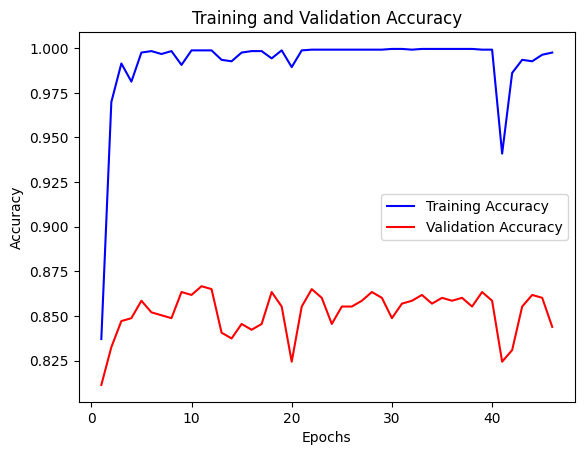

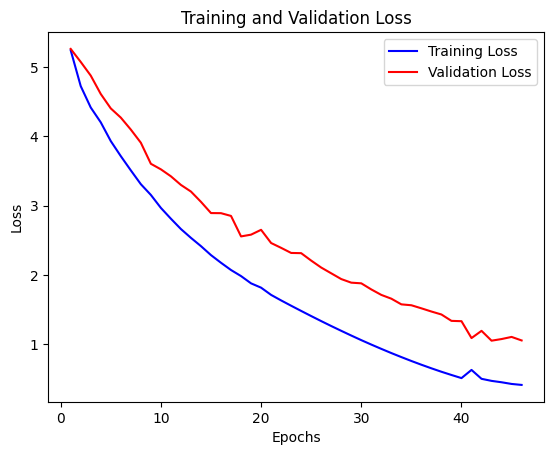

In [54]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step
Accuracy on test dataset: 0.4967

Classification Report:
               precision    recall  f1-score   support

    fracture       0.50      0.54      0.52       387
  nofracture       0.49      0.46      0.47       380

    accuracy                           0.50       767
   macro avg       0.50      0.50      0.50       767
weighted avg       0.50      0.50      0.50       767



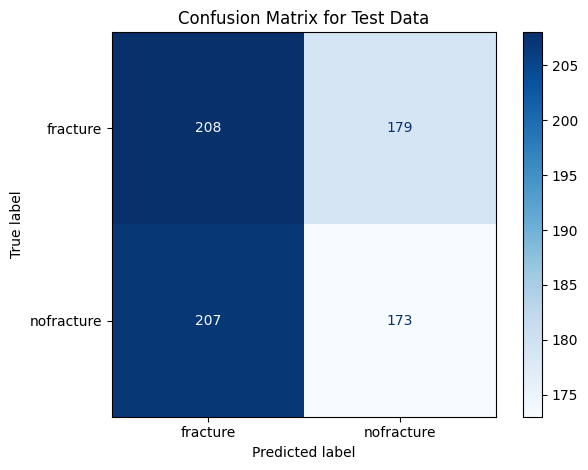

In [55]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_2, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step
AUC: 0.4917


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


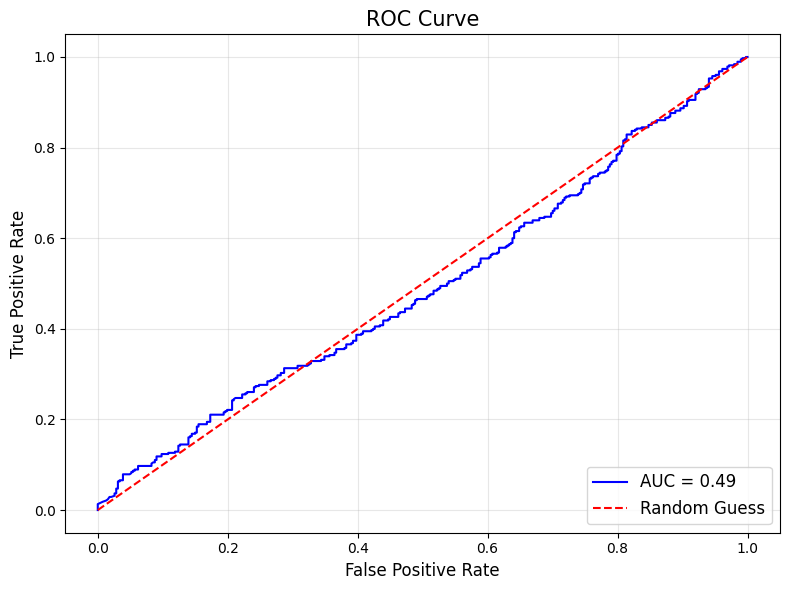

In [56]:
auc = plot_auc_curve(model_VGG16_2, test_ds)

-----------

-----------

### *Model 3*

In [6]:
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True

In [7]:
#Extract features
train_features, train_labels = extract_features(conv_base_VGG16, train_ds)
val_features, val_labels = extract_features(conv_base_VGG16, val_ds)
test_features, test_labels = extract_features(conv_base_VGG16, test_ds)

I0000 00:00:1740727872.851774  183764 service.cc:148] XLA service 0x7f3ae0006c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740727872.851792  183764 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-02-28 08:31:12.860805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740727872.917340  183764 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-28 08:31:13.203027: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backen

In [8]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

Due to the processing time, the next cell was run using a nohup process aTo run the code, I used:

nohup python3 random_forest_VGG16.py 

The result is saved in a file called nohup.out

In [ ]:
#Training the Machine Learning Model

params = [{
    "n_estimators": [100, 500, 1000, 1500],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(1, 100),
    "min_samples_split": range(100, 501)
}]
sduos
#Random forest
random_forest = RandomizedSearchCV(RandomForestClassifier(), params, cv = 5, n_iter = 1000, verbose = 1, random_state=42, n_jobs = 6)
random_forest.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(random_forest.best_estimator_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


Best estimator found by random search:
RandomForestClassifier(max_depth=82, min_samples_split=114, n_estimators=500)


In [9]:
random_forest = RandomForestClassifier(max_depth=82, min_samples_split=114, n_estimators=500)
random_forest.fit(train_features, np.ravel(train_labels))

RandomForestClassifier(max_depth=82, min_samples_split=114, n_estimators=500)

Accuracy in test: 0.7066492829204694
              precision    recall  f1-score   support

         0.0       0.69      0.76      0.72       387
         1.0       0.73      0.65      0.69       380

    accuracy                           0.71       767
   macro avg       0.71      0.71      0.71       767
weighted avg       0.71      0.71      0.71       767



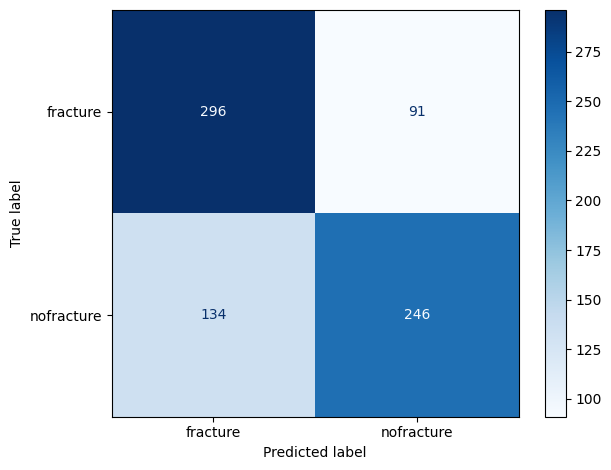

In [10]:
#Evaluating the model
test_predictions = random_forest.predict(test_features)
print("Accuracy in test:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.7681


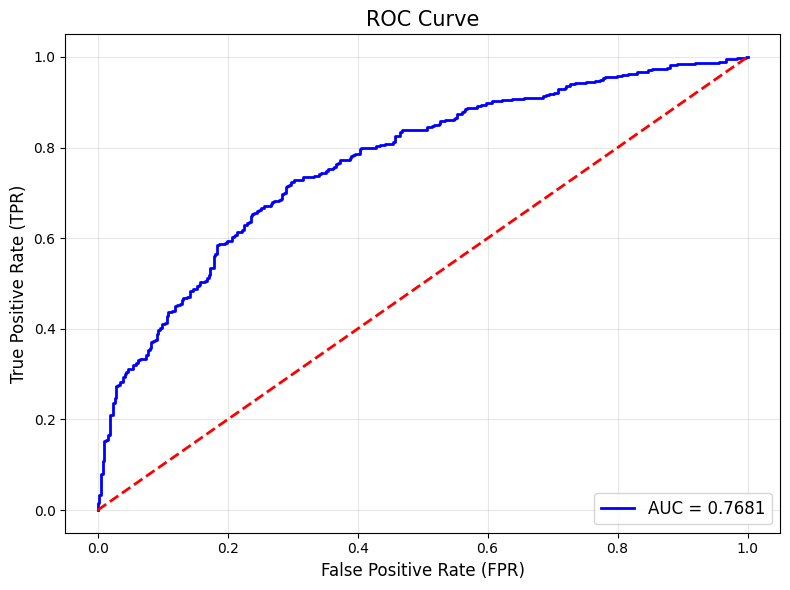

In [11]:
#Obtaining probability for positive class (1)
test_probabilities = random_forest.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Due to the processing time, the next cell was run aisled the cell and the previous lines associated to the cell (see svc_VGG16.py) an run in a remote server using ssh connection. To run the code, I used:

nohup python3 svc_VGG16.py 

The result is saved in a file called nohup.out

In [ ]:
params =[{
    "C":[0.1, 1, 10, 100, 1000],
    "kernel":["linear", "poly", "rbf", "sigmoid"],
    "degree":[1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"],
    "shrinking":[True, False],
    "tol": [1e-1, 1e-2, 1e-3],
    "class_weight":["dict", "balance", None],
    "decision_function_shape":["ovo", "ovr"]     
}] 

#Random forest
svc = RandomizedSearchCV(SVC(), params, cv = 5, n_iter = 1000, verbose = 1, random_state=42, n_jobs = 6)
svc.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(svc.best_estimator_)

Best estimator found by random search:
SVC(C=1000, degree=1, tol=0.1)

In [9]:
svc = SVC(C=1000, degree=1, tol=0.1, probability=True)
svc.fit(train_features, np.ravel(train_labels))

SVC(C=1000, degree=1, probability=True, tol=0.1)

Accuracy in test: 0.7822685788787483
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78       387
         1.0       0.78      0.78      0.78       380

    accuracy                           0.78       767
   macro avg       0.78      0.78      0.78       767
weighted avg       0.78      0.78      0.78       767



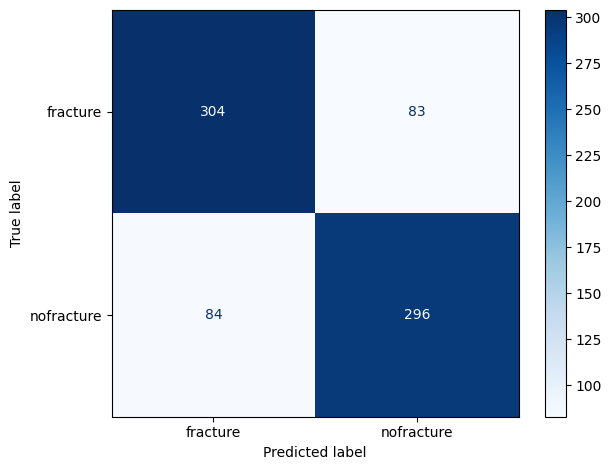

In [10]:
#Evaluating the model
test_predictions = svc.predict(test_features)
print("Accuracy in test:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.8710


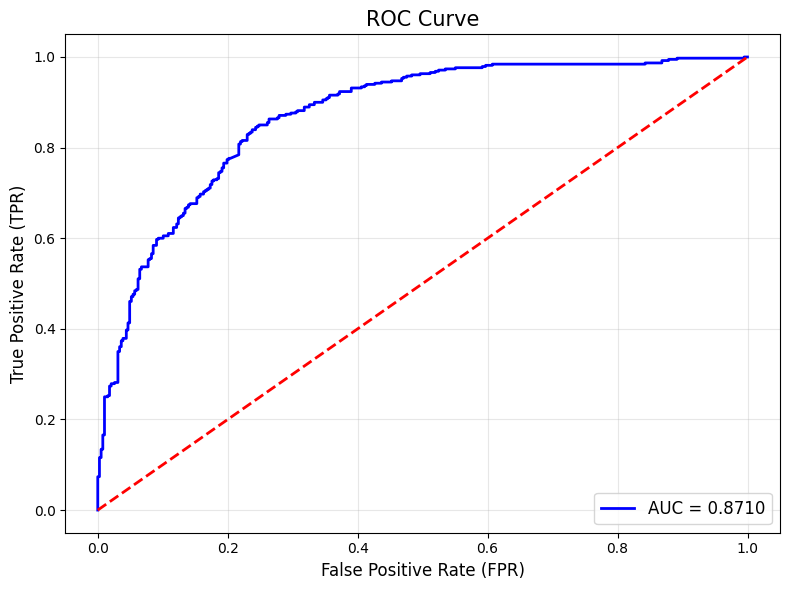

In [11]:
#Obtaining probability for positive class (1)
test_probabilities = svc.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Due to the processing time, the next cell was run aisled the cell and the previous lines associated to the cell (see xgboost_VGG16.py) an run in a remote server using ssh connection. To run the code, I used:

nohup python3 xgboost_VGG16.py 

The result is saved in a file called nohup.out

In [ ]:
num_classes = len(np.unique(train_labels))
params = [{
    "booster": ["gbtree"],
    "eta": [0.1, 0.05], 
    "gamma": [0.1, 0.5],  
    "max_depth": [3, 4],  
    "min_child_weight": [100, 200],  
    "subsample": [0.8, 1.0],  
    "colsample_bytree": [0.8, 0.9],  
    "lambda": [0.01, 0.1],  
    "alpha": [0.01, 0.1],  
    "tree_method": ["hist"],  
    "objective": ["multi:softmax"]  
}]

xgb = RandomizedSearchCV(XGBClassifier(objective="multi:softmax", num_class=num_classes), params, cv = 5, n_iter = 100, verbose = 1, n_jobs = 2)
xgb.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(xgb.best_estimator_)

Best estimator found by random search:
XGBClassifier(booster = 'gbtree', eta = 0.1, gamma = 0.5, max_depth = 4, min_child_weight = 100, subsample = 0.8, colsample_bytree=0.8, reg_lambda = 0.01,
        alpha = 0.01, tree_method = "hist", objective = "multi:softmax", num_class=num_classes)


In [16]:
num_classes = len(np.unique(train_labels))

xgb = XGBClassifier(booster = 'gbtree', eta = 0.1, gamma = 0.5, max_depth = 4, min_child_weight = 100, subsample = 0.8, colsample_bytree=0.8, reg_lambda = 0.01,
        alpha = 0.01, tree_method = "hist", objective = "multi:softmax", num_class=num_classes)

xgb.fit(train_features, np.ravel(train_labels))


XGBClassifier(alpha=0.01, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=100, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

Accuracy in test: 0.757496740547588
              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77       387
         1.0       0.77      0.73      0.75       380

    accuracy                           0.76       767
   macro avg       0.76      0.76      0.76       767
weighted avg       0.76      0.76      0.76       767



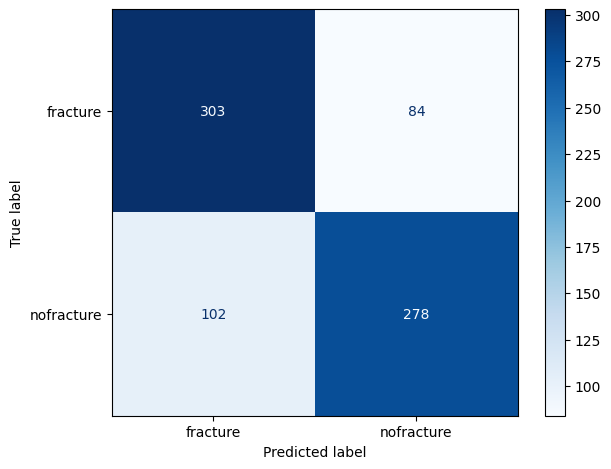

In [17]:
#Evaluating the model
test_predictions = xgb.predict(test_features)
print("Accuracy in test:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.8278


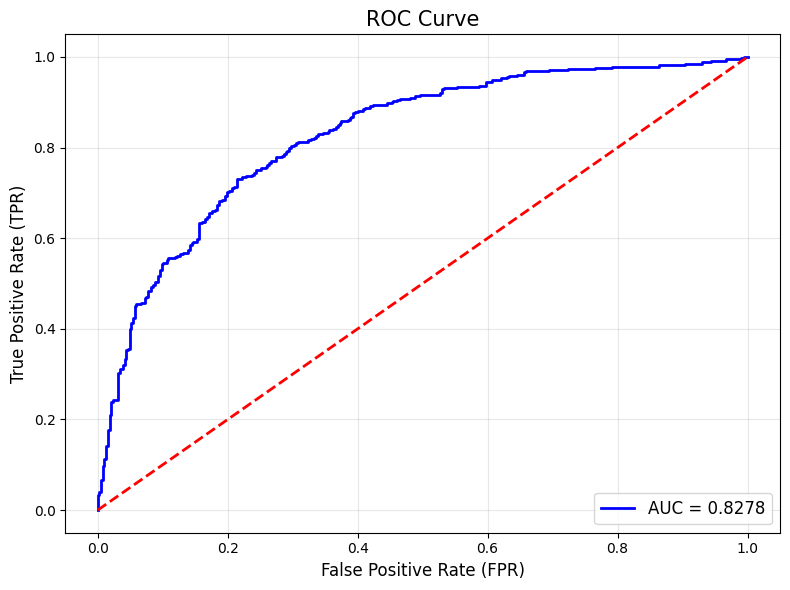

In [18]:
#Obtaining probability for positive class (1)
test_probabilities = xgb.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Due to the processing time, the next cell was run aisled the cell and the previous lines associated to the cell (see lgb_VGG16.py) an run in a remote server using ssh connection. To run the code, I used:

nohup python3 lgb_VGG16.py 

The result is saved in a file called nohup.out

In [ ]:
num_classes = len(np.unique(train_labels))
params = [{
    "n_estimators": [500, 1000],  
    "learning_rate": [0.1, 0.05],  
    "max_depth": [5, 7],  
    "num_leaves": [31, 63],  
    "min_child_samples": [20, 50],  
    "reg_alpha": [0.01, 0.1],  
    "reg_lambda": [0.01, 0.1],  
    "subsample": [0.8, 1.0],  
    "colsample_bytree": [0.8, 0.9],  
    "boosting_type": ["gbdt"],  
    "objective": ["multiclass"],  
    "metric": ["multi_logloss"],  
}]

lgb = RandomizedSearchCV(LGBMClassifier(num_classes = num_classes), params, cv = 5, n_iter = 100, verbose = 0, n_jobs = 2)
lgb.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(lgb.best_estimator_)

Best estimator found by random search:
LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               metric='multi_logloss', min_child_samples=50, n_estimators=1000,
               num_classes=2, num_leaves=63, objective='multiclass',
               reg_alpha=0.01, reg_lambda=0.01)

In [11]:
lgb = LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7, metric='multi_logloss', min_child_samples=50, n_estimators=1000,num_classes=2, 
                     num_leaves=63, objective='multiclass', reg_alpha=0.01, reg_lambda=0.01)

lgb.fit(train_features, np.ravel(train_labels))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.541902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2745325
[LightGBM] [Info] Number of data points in the train set: 3140, number of used features: 16030
[LightGBM] [Info] Start training from score -0.930726
[LightGBM] [Info] Start training from score -0.501317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               metric='multi_logloss', min_child_samples=50, n_estimators=1000,
               num_classes=2, num_leaves=63, objective='multiclass',
               reg_alpha=0.01, reg_lambda=0.01)

Accuracy in test: 0.8396349413298566
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81       387
         1.0       0.76      1.00      0.86       380

    accuracy                           0.84       767
   macro avg       0.88      0.84      0.84       767
weighted avg       0.88      0.84      0.84       767



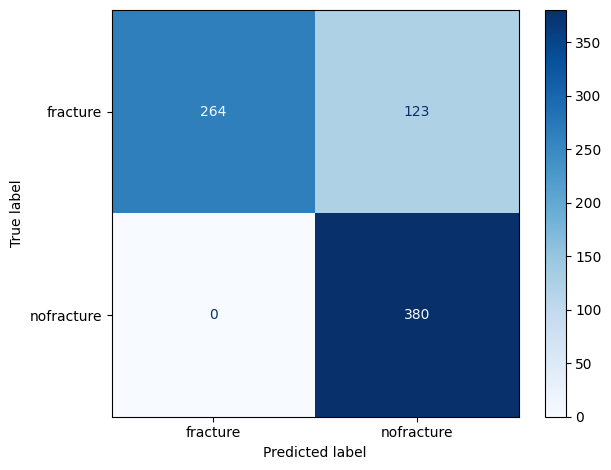

In [12]:
#Evaluating the model
test_predictions = lgb.predict(test_features)
print("Accuracy in test:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.9969


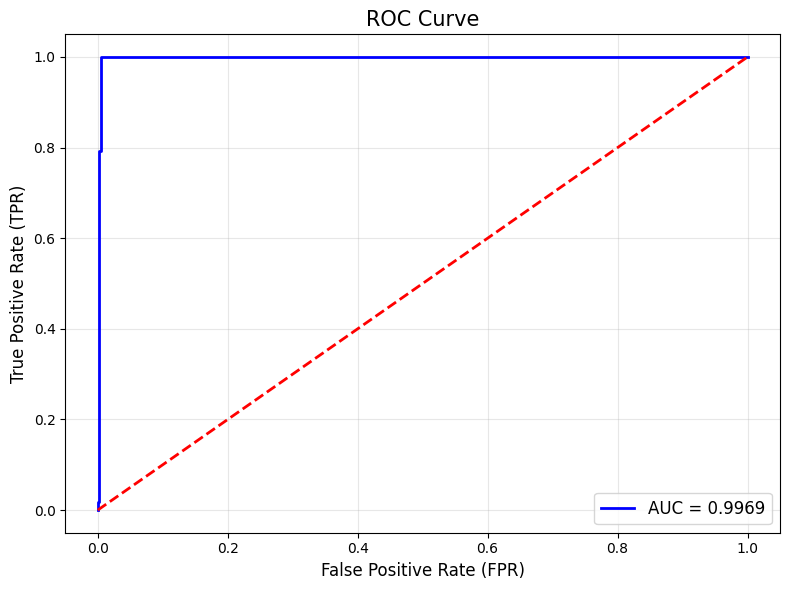

In [13]:
#Obtaining probability for positive class (1)
test_probabilities = lgb.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

--------

**Model 3.1**

In [8]:
#Unfreezing the lats 12 layers
for layer in conv_base_VGG16.layers[-12:]:
    layer.trainable = True

In [9]:
#Extract features
train_features, train_labels = extract_features(conv_base_VGG16, train_ds)
val_features, val_labels = extract_features(conv_base_VGG16, val_ds)
test_features, test_labels = extract_features(conv_base_VGG16, test_ds)

I0000 00:00:1737621873.897330 2335268 service.cc:148] XLA service 0x7f3bd8003860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737621873.897351 2335268 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-01-23 09:44:33.906444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737621873.962901 2335268 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-23 09:44:34.257626: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backen

In [10]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

Due to the processing time, the next cell was run aisled the cell and the previous lines associated to the cell (see random_forest_VGG16_12.py) an run in a remote server using ssh connection. To run the code, I used:

nohup python3 random_forest_VGG16_12.py 

The result is saved in a file called nohup.out

In [ ]:
#Training the Machine Learning Model

params = [{
    "n_estimators": [100, 500, 1000, 1500],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(1, 100),
    "min_samples_split": range(100, 501)
}]

#Random forest
random_forest = RandomizedSearchCV(RandomForestClassifier(), params, cv = 5, n_iter = 1000, verbose = 1, random_state=42, n_jobs = 6)
random_forest.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(random_forest.best_estimator_)

In [11]:
random_forest = RandomForestClassifier(max_depth=70, min_samples_split=102, n_estimators=1500)
random_forest.fit(train_features, np.ravel(train_labels))

RandomForestClassifier(max_depth=70, min_samples_split=102, n_estimators=1500)

Accuracy in test: 0.6427640156453716
              precision    recall  f1-score   support

         0.0       0.99      0.29      0.45       387
         1.0       0.58      1.00      0.73       380

    accuracy                           0.64       767
   macro avg       0.79      0.65      0.59       767
weighted avg       0.79      0.64      0.59       767



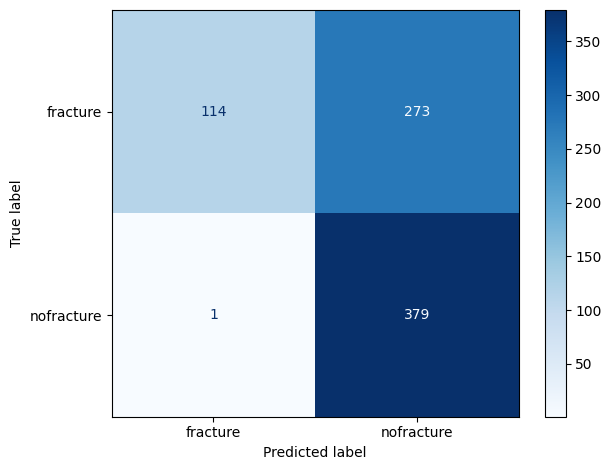

In [12]:
#Evaluating the model
test_predictions = random_forest.predict(test_features)
print("Accuracy in test:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.9401


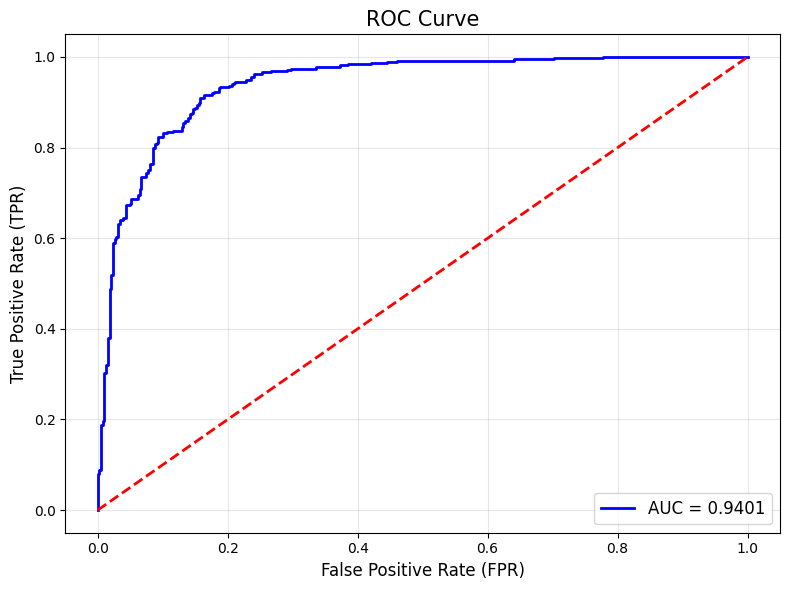

In [13]:
#Obtaining probability for positive class (1)
test_probabilities = random_forest.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

-----------------

### **Pretrained network ResNet-50**

In [5]:
#Load ResNet
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freezing the layers
resnet_base.trainable = False

resnet_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

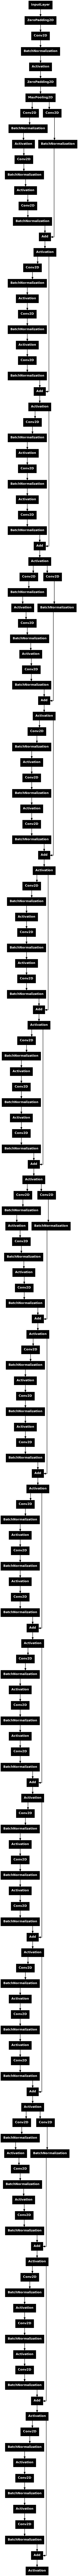

In [8]:
tf.keras.utils.plot_model(resnet_base)

### *Loading and preprocesing images*

In [6]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [7]:
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(224, 224)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255)

### *Model 1*

In [7]:
model_resnet_1 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_1.add(resnet_base)

# Add personalized layers
model_resnet_1.add(layers.Flatten())  # Flatten extracted features
model_resnet_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_1.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_1.add(layers.Dense(1, activation='sigmoid'))

model_resnet_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

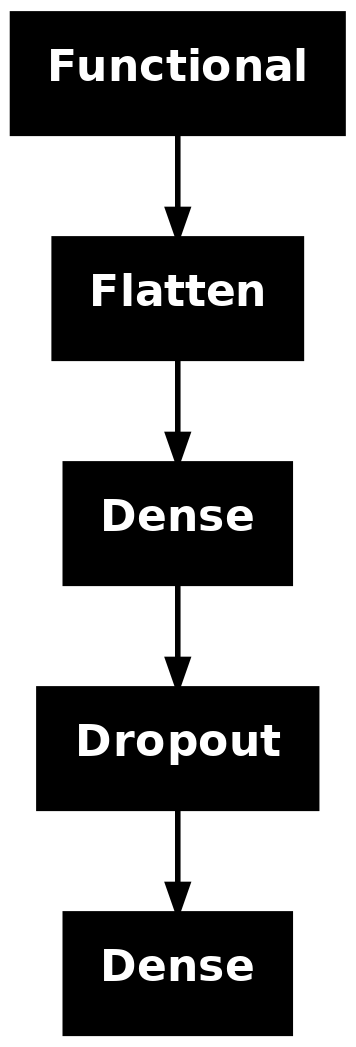

In [10]:
tf.keras.utils.plot_model(model_resnet_1)

In [8]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_resnet_1, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


I0000 00:00:1734344800.850106 3601897 service.cc:148] XLA service 0x7fcf4c04df20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734344800.850535 3601897 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-16 11:26:41.475392: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734344802.470384 3601897 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-16 11:26:43.490887: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_

  1/130 ━━━━━━━━━━━━━━━━━━━━ 24:18 11s/step - accuracy: 0.4062 - loss: 5.8587

I0000 00:00:1734344807.031580 3601897 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5135 - loss: 5.4198

2024-12-16 11:26:55.850335: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[4,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-16 11:26:56.030506: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[4,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivati

 99/130 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5138 - loss: 5.4155

2024-12-16 11:26:58.212381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-16 11:26:58.212592: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-16 11:27:03.539935: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x

130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - accuracy: 0.5199 - loss: 5.3155 - val_accuracy: 0.4959 - val_loss: 4.2019 - learning_rate: 1.0000e-05
Epoch 2/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5611 - loss: 3.8858

2024-12-16 11:27:13.710119: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5656 - loss: 3.8164 - val_accuracy: 0.4959 - val_loss: 3.1162 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5879 - loss: 2.7883 - val_accuracy: 0.4959 - val_loss: 2.3417 - learning_rate: 1.0000e-05
Epoch 4/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5737 - loss: 2.1306

2024-12-16 11:27:32.716221: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5784 - loss: 2.0955 - val_accuracy: 0.4959 - val_loss: 1.8101 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5976 - loss: 1.6129 - val_accuracy: 0.4959 - val_loss: 1.4444 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5949 - loss: 1.3117 - val_accuracy: 0.4959 - val_loss: 1.1809 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5961 - loss: 1.0983 - val_accuracy: 0.4959 - val_loss: 1.0455 - learning_rate: 1.0000e-05
Epoch 8/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5990 - loss: 0.9713

2024-12-16 11:28:10.898876: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6007 - loss: 0.9654 - val_accuracy: 0.4959 - val_loss: 0.9482 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5940 - loss: 0.8891 - val_accuracy: 0.4959 - val_loss: 0.8859 - learning_rate: 1.0000e-05
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6005 - loss: 0.8366 - val_accuracy: 0.4959 - val_loss: 0.8523 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6024 - loss: 0.8056 - val_accuracy: 0.4959 - val_loss: 0.8350 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5972 - loss: 0.7913 - val_accuracy: 0.4959 - val_loss: 0.8206 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5979 - loss: 0.7807 - val_accuracy: 0.4959 - val_loss: 0.8227 - learning_rate: 1.0000e-05
Epoch 14/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step 

2024-12-16 11:29:27.319858: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5998 - loss: 0.7676 - val_accuracy: 0.4959 - val_loss: 0.7985 - learning_rate: 1.0000e-05
Epoch 17/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5951 - loss: 0.7645 - val_accuracy: 0.4959 - val_loss: 0.7994 - learning_rate: 1.0000e-05
Epoch 18/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5996 - loss: 0.7614 - val_accuracy: 0.4959 - val_loss: 0.7957 - learning_rate: 1.0000e-05
Epoch 19/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5967 - loss: 0.7608 - val_accuracy: 0.4959 - val_loss: 0.7954 - learning_rate: 1.0000e-05
Epoch 20/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5970 - loss: 0.7587 - val_accuracy: 0.4959 - val_loss: 0.7941 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5994 - loss: 0.7560 - val_accuracy: 0.4959 - val_loss: 0.7928 - learning_rate: 1.0000e-05
Epoch 22/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step 

2024-12-16 11:32:00.967303: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.6012 - loss: 0.7338 - val_accuracy: 0.4959 - val_loss: 0.7771 - learning_rate: 1.0000e-05
Epoch 33/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5974 - loss: 0.7326 - val_accuracy: 0.4959 - val_loss: 0.7752 - learning_rate: 1.0000e-05
Epoch 34/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5914 - loss: 0.7352 - val_accuracy: 0.4959 - val_loss: 0.7684 - learning_rate: 1.0000e-05
Epoch 35/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5950 - loss: 0.7328 - val_accuracy: 0.4959 - val_loss: 0.7724 - learning_rate: 1.0000e-05
Epoch 36/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5990 - loss: 0.7286 - val_accuracy: 0.4959 - val_loss: 0.7682 - learning_rate: 1.0000e-05
Epoch 37/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5974 - loss: 0.7284 - val_accuracy: 0.4959 - val_loss: 0.7663 - learning_rate: 1.0000e-05
Epoch 38/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/ste

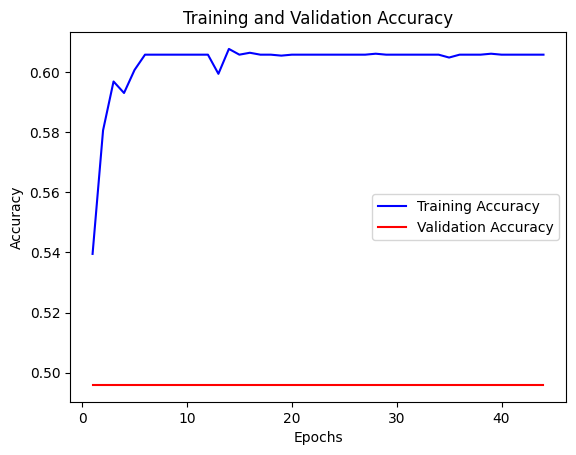

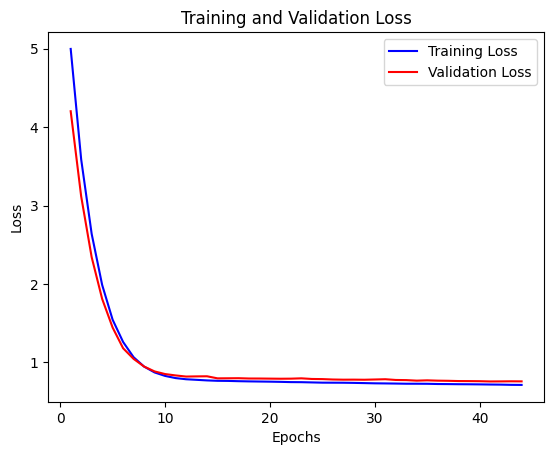

In [10]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

----------

### *Model 2*

In [11]:
model_resnet_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_2.add(resnet_base)

# Add personalized layers
model_resnet_2.add(layers.GlobalAveragePooling2D())
model_resnet_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_2.add(layers.Dense(1, activation='sigmoid'))

model_resnet_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

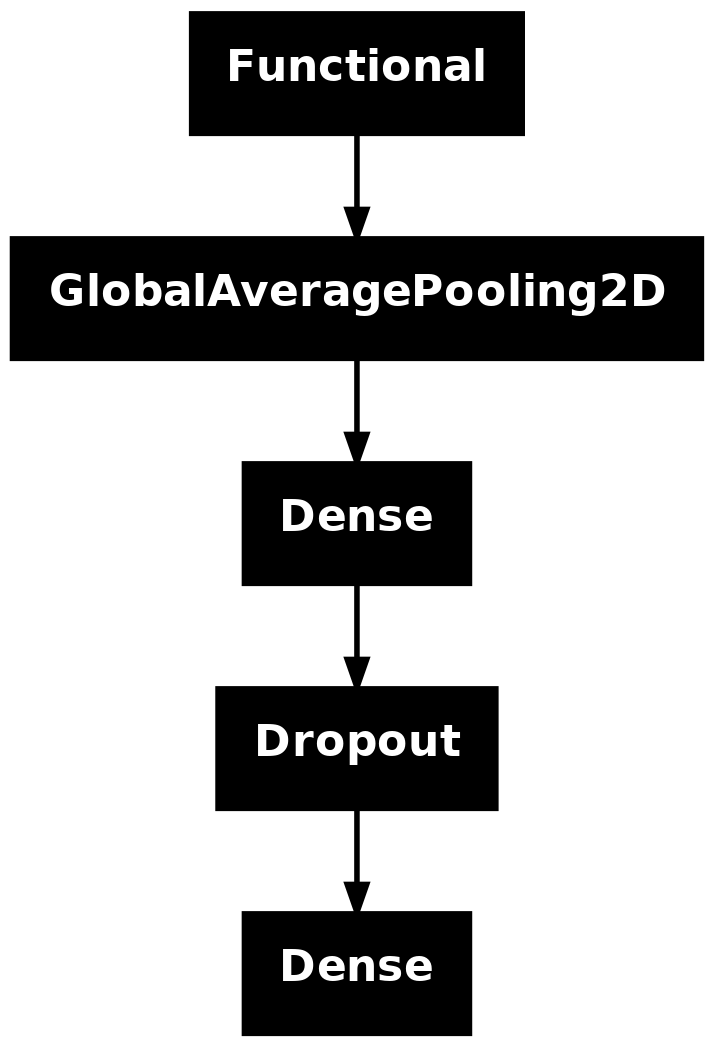

In [38]:
tf.keras.utils.plot_model(model_resnet_2)

In [12]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 

history = train_model(model_resnet_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.5775 - loss: 5.1860 - val_accuracy: 0.4959 - val_loss: 5.0201 - learning_rate: 1.0000e-05
Epoch 2/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5336 - loss: 4.9606

2024-12-16 11:35:21.687358: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5388 - loss: 4.9428 - val_accuracy: 0.4959 - val_loss: 4.7896 - learning_rate: 1.0000e-05
Epoch 3/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5764 - loss: 4.7110

2024-12-16 11:35:30.611792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401
2024-12-16 11:35:30.611875: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4442758681475272302


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5738 - loss: 4.6981 - val_accuracy: 0.4959 - val_loss: 4.5649 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5743 - loss: 4.4818 - val_accuracy: 0.4959 - val_loss: 4.3515 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5570 - loss: 4.2798 - val_accuracy: 0.4959 - val_loss: 4.1571 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5503 - loss: 4.0843 - val_accuracy: 0.4959 - val_loss: 3.9656 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5637 - loss: 3.8919 - val_accuracy: 0.4959 - val_loss: 3.7893 - learning_rate: 1.0000e-05
Epoch 8/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5546 - loss: 3.7229

2024-12-16 11:36:15.724422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5580 - loss: 3.7107 - val_accuracy: 0.4959 - val_loss: 3.6177 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5590 - loss: 3.5485 - val_accuracy: 0.4959 - val_loss: 3.4561 - learning_rate: 1.0000e-05
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5672 - loss: 3.3843 - val_accuracy: 0.4959 - val_loss: 3.2988 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5592 - loss: 3.2382 - val_accuracy: 0.4959 - val_loss: 3.1566 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5589 - loss: 3.0908 - val_accuracy: 0.4959 - val_loss: 3.0167 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5711 - loss: 2.9510 - val_accuracy: 0.4959 - val_loss: 2.8847 - learning_rate: 1.0000e-05
Epoch 14/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - acc

2024-12-16 11:38:04.147140: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5782 - loss: 2.1740 - val_accuracy: 0.4959 - val_loss: 2.1361 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5558 - loss: 2.0865 - val_accuracy: 0.4959 - val_loss: 2.0489 - learning_rate: 1.0000e-05
Epoch 22/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5762 - loss: 1.9912 - val_accuracy: 0.4959 - val_loss: 1.9673 - learning_rate: 1.0000e-05
Epoch 23/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5807 - loss: 1.9073 - val_accuracy: 0.4959 - val_loss: 1.8897 - learning_rate: 1.0000e-05
Epoch 24/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5743 - loss: 1.8378 - val_accuracy: 0.4959 - val_loss: 1.8180 - learning_rate: 1.0000e-05
Epoch 25/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5814 - loss: 1.7633

2024-12-16 11:38:49.489156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5832 - loss: 1.7590 - val_accuracy: 0.4959 - val_loss: 1.7483 - learning_rate: 1.0000e-05
Epoch 26/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5716 - loss: 1.6972 - val_accuracy: 0.4959 - val_loss: 1.6821 - learning_rate: 1.0000e-05
Epoch 27/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5634 - loss: 1.6319 - val_accuracy: 0.4959 - val_loss: 1.6190 - learning_rate: 1.0000e-05
Epoch 28/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5742 - loss: 1.5721 - val_accuracy: 0.4959 - val_loss: 1.5616 - learning_rate: 1.0000e-05
Epoch 29/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5685 - loss: 1.5089 - val_accuracy: 0.4959 - val_loss: 1.5087 - learning_rate: 1.0000e-05
Epoch 30/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5806 - loss: 1.4581 - val_accuracy: 0.4959 - val_loss: 1.4558 - learning_rate: 1.0000e-05
Epoch 31/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - ac

2024-12-16 11:41:05.660807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401
2024-12-16 11:41:05.660841: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4442758681475272302


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5926 - loss: 1.0653 - val_accuracy: 0.4959 - val_loss: 1.0867 - learning_rate: 1.0000e-05
Epoch 41/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5833 - loss: 1.0411 - val_accuracy: 0.4959 - val_loss: 1.0630 - learning_rate: 1.0000e-05
Epoch 42/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5786 - loss: 1.0224 - val_accuracy: 0.4959 - val_loss: 1.0439 - learning_rate: 1.0000e-05
Epoch 43/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5861 - loss: 1.0040 - val_accuracy: 0.4959 - val_loss: 1.0212 - learning_rate: 1.0000e-05
Epoch 44/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5868 - loss: 0.9766 - val_accuracy: 0.4959 - val_loss: 1.0041 - learning_rate: 1.0000e-05
Epoch 45/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5933 - loss: 0.9547 - val_accuracy: 0.4959 - val_loss: 0.9839 - learning_rate: 1.0000e-05
Epoch 46/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - ac

2024-12-16 11:42:54.566095: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5876 - loss: 0.8653 - val_accuracy: 0.4959 - val_loss: 0.8909 - learning_rate: 1.0000e-05
Epoch 53/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5854 - loss: 0.8522 - val_accuracy: 0.4959 - val_loss: 0.8836 - learning_rate: 1.0000e-05
Epoch 54/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5913 - loss: 0.8425 - val_accuracy: 0.4959 - val_loss: 0.8754 - learning_rate: 1.0000e-05
Epoch 55/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5918 - loss: 0.8324 - val_accuracy: 0.4959 - val_loss: 0.8714 - learning_rate: 1.0000e-05
Epoch 56/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5841 - loss: 0.8331

2024-12-16 11:43:30.906223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401
2024-12-16 11:43:30.906250: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4442758681475272302


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5894 - loss: 0.8306 - val_accuracy: 0.4959 - val_loss: 0.8620 - learning_rate: 1.0000e-05
Epoch 57/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5950 - loss: 0.8208 - val_accuracy: 0.4959 - val_loss: 0.8551 - learning_rate: 1.0000e-05
Epoch 58/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5900 - loss: 0.8179 - val_accuracy: 0.4959 - val_loss: 0.8519 - learning_rate: 1.0000e-05
Epoch 59/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5904 - loss: 0.8067

2024-12-16 11:43:59.287903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5935 - loss: 0.8056 - val_accuracy: 0.4959 - val_loss: 0.8458 - learning_rate: 1.0000e-05
Epoch 60/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5874 - loss: 0.8060 - val_accuracy: 0.4959 - val_loss: 0.8419 - learning_rate: 1.0000e-05
Epoch 61/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5930 - loss: 0.8020 - val_accuracy: 0.4959 - val_loss: 0.8380 - learning_rate: 1.0000e-05
Epoch 62/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5949 - loss: 0.7979 - val_accuracy: 0.4959 - val_loss: 0.8342 - learning_rate: 1.0000e-05
Epoch 63/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5926 - loss: 0.7929 - val_accuracy: 0.4959 - val_loss: 0.8308 - learning_rate: 1.0000e-05
Epoch 64/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5971 - loss: 0.7915 - val_accuracy: 0.4959 - val_loss: 0.8296 - learning_rate: 1.0000e-05
Epoch 65/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - ac

2024-12-16 11:45:02.966937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5985 - loss: 0.7856 - val_accuracy: 0.4959 - val_loss: 0.8270 - learning_rate: 1.0000e-05
Epoch 67/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5891 - loss: 0.7824 - val_accuracy: 0.4959 - val_loss: 0.8221 - learning_rate: 1.0000e-05
Epoch 68/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5907 - loss: 0.7831 - val_accuracy: 0.4959 - val_loss: 0.8214 - learning_rate: 1.0000e-05
Epoch 69/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5908 - loss: 0.7782

2024-12-16 11:45:30.194140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401
2024-12-16 11:45:30.194169: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4442758681475272302


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5937 - loss: 0.7772 - val_accuracy: 0.4959 - val_loss: 0.8188 - learning_rate: 1.0000e-05
Epoch 70/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5902 - loss: 0.7794 - val_accuracy: 0.4959 - val_loss: 0.8126 - learning_rate: 1.0000e-05
Epoch 71/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5902 - loss: 0.7769 - val_accuracy: 0.4959 - val_loss: 0.8164 - learning_rate: 1.0000e-05
Epoch 72/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5889 - loss: 0.7765 - val_accuracy: 0.4959 - val_loss: 0.8119 - learning_rate: 1.0000e-05
Epoch 73/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5926 - loss: 0.7749 - val_accuracy: 0.4959 - val_loss: 0.8120 - learning_rate: 1.0000e-05
Epoch 74/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5939 - loss: 0.7710 - val_accuracy: 0.4959 - val_loss: 0.8100 - learning_rate: 1.0000e-05
Epoch 75/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - ac

2024-12-16 11:47:46.724758: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5928 - loss: 0.7603 - val_accuracy: 0.4959 - val_loss: 0.8021 - learning_rate: 1.0000e-05
Epoch 85/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5944 - loss: 0.7587 - val_accuracy: 0.4959 - val_loss: 0.7988 - learning_rate: 1.0000e-05
Epoch 86/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5971 - loss: 0.7588 - val_accuracy: 0.4959 - val_loss: 0.8007 - learning_rate: 1.0000e-05
Epoch 87/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5977 - loss: 0.7568 - val_accuracy: 0.4959 - val_loss: 0.7977 - learning_rate: 1.0000e-05
Epoch 88/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5972 - loss: 0.7555 - val_accuracy: 0.4959 - val_loss: 0.7979 - learning_rate: 1.0000e-05
Epoch 89/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5960 - loss: 0.7583 - val_accuracy: 0.4959 - val_loss: 0.7950 - learning_rate: 1.0000e-05
Epoch 90/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - ac

2024-12-16 11:49:45.530394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5961 - loss: 0.7499 - val_accuracy: 0.4959 - val_loss: 0.7934 - learning_rate: 1.0000e-05
Epoch 98/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5892 - loss: 0.7516 - val_accuracy: 0.4959 - val_loss: 0.7919 - learning_rate: 5.0000e-06
Epoch 99/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.6002 - loss: 0.7457 - val_accuracy: 0.4959 - val_loss: 0.7915 - learning_rate: 5.0000e-06
Epoch 100/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5979 - loss: 0.7459 - val_accuracy: 0.4959 - val_loss: 0.7896 - learning_rate: 5.0000e-06


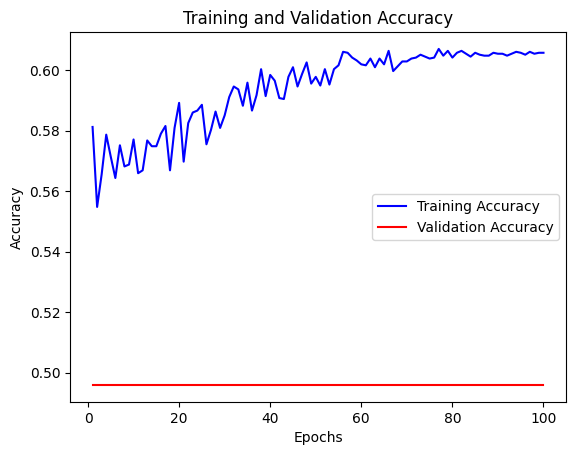

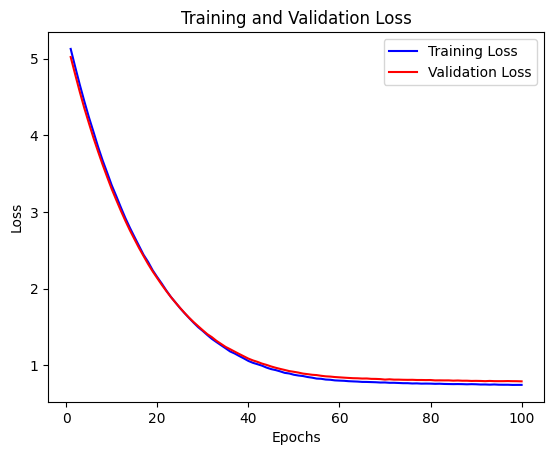

In [14]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

--------------------------

### *Model 3*

In [8]:
for layer in resnet_base.layers[50:]:
    layer.trainable = True

In [9]:
#Extract features
train_features, train_labels = extract_features(resnet_base, train_ds)
val_features, val_labels = extract_features(resnet_base, val_ds)
test_features, test_labels = extract_features(resnet_base, test_ds)

I0000 00:00:1737444005.163628 1730927 service.cc:148] XLA service 0x7fd198048560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737444005.163899 1730927 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-01-21 08:20:05.270021: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737444005.711521 1730927 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-21 08:20:06.720690: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_

In [10]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

Due to the processing time, the next cell was run aisled the cell and the previous lines associated to the cell (see random_forest_resnet50.py) an run in a remote server using ssh connection. To run the code, I used:

nohup python3 random_forest_resnet50.py 

The result is saved in a file called nohup.out

In [ ]:
#Training the Machine Learning Model

#Random forest
params = [{
    "n_estimators": [100, 500, 1000, 1500],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(1, 100),
    "min_samples_split": range(100, 501)
}]

#Random forest
random_forest = RandomizedSearchCV(RandomForestClassifier(), params, cv = 5, n_iter = 1000, verbose = 1, random_state=42, n_jobs = 6)
random_forest.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(random_forest.best_estimator_)

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

Best estimator found by random search:
RandomForestClassifier(criterion='entropy', max_depth=49, min_samples_split=102)

In [39]:
random_forest = RandomForestClassifier(criterion='entropy', max_depth=49, min_samples_split=102)
random_forest.fit(train_features, np.ravel(train_labels))

RandomForestClassifier(criterion='entropy', max_depth=49, min_samples_split=102)

Accuracy en validación: 0.559322033898305
              precision    recall  f1-score   support

         0.0       0.96      0.13      0.23       387
         1.0       0.53      0.99      0.69       380

    accuracy                           0.56       767
   macro avg       0.75      0.56      0.46       767
weighted avg       0.75      0.56      0.46       767



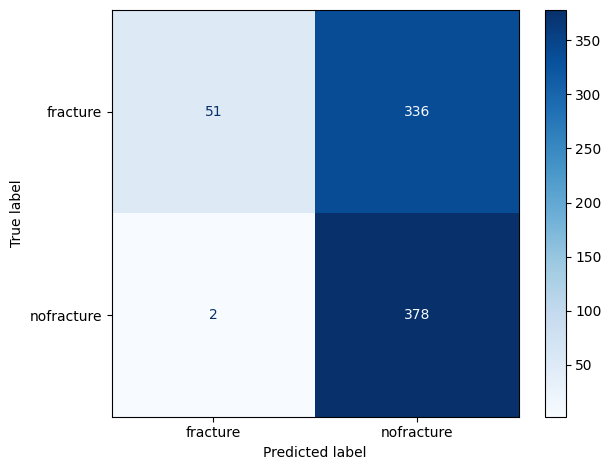

In [40]:
#Evaluating the model
test_predictions = random_forest.predict(test_features)
print("Accuracy en validación:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.8731


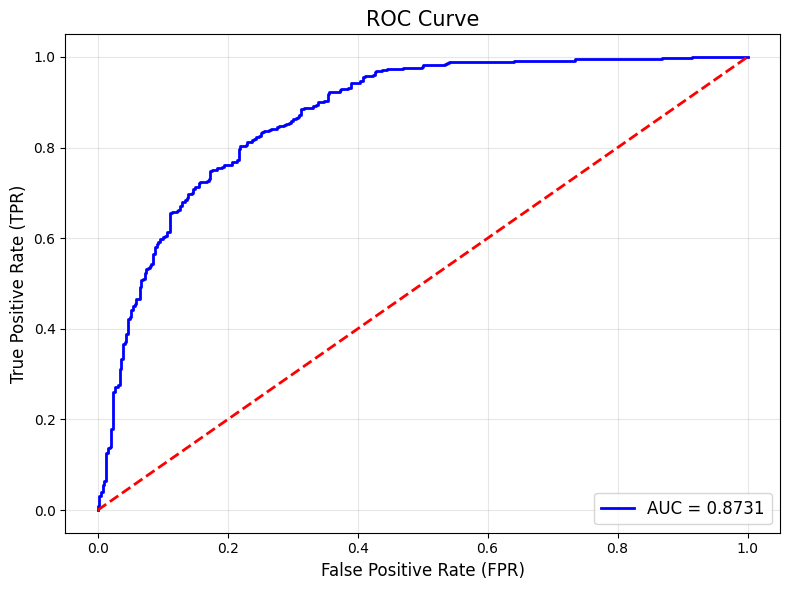

In [41]:
#Obtaining probability for positive class (1)
test_probabilities = random_forest.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Due to the processing time, this part of the code was nor runned

params = [{
    "C": [10, 100, 1000],
    "kernel": ["linear", "rbf"],  # Reduced kernels
    "gamma": ["scale", "auto"],
    "shrinking": [True, False],
    "tol": [1e-1, 1e-3],  # Focused tolerance
    "class_weight": [None, "balanced"],
    "decision_function_shape": ["ovo", "ovr"]
}]

#Random forest
svc = RandomizedSearchCV(SVC(), params, cv = 5, n_iter = 1000, verbose = 1, random_state=42, n_jobs = 6)
svc.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(svc.best_estimator_)

In [11]:
#This was the best SVC model for VGG16
svc = SVC(C=10, degree=5, kernel='poly', tol=0.01, probability=True)
svc.fit(train_features, np.ravel(train_labels))

SVC(C=10, degree=5, kernel='poly', probability=True, tol=0.01)

Accuracy en validación: 0.5110821382007823
              precision    recall  f1-score   support

         0.0       0.88      0.04      0.07       387
         1.0       0.50      0.99      0.67       380

    accuracy                           0.51       767
   macro avg       0.69      0.52      0.37       767
weighted avg       0.69      0.51      0.37       767



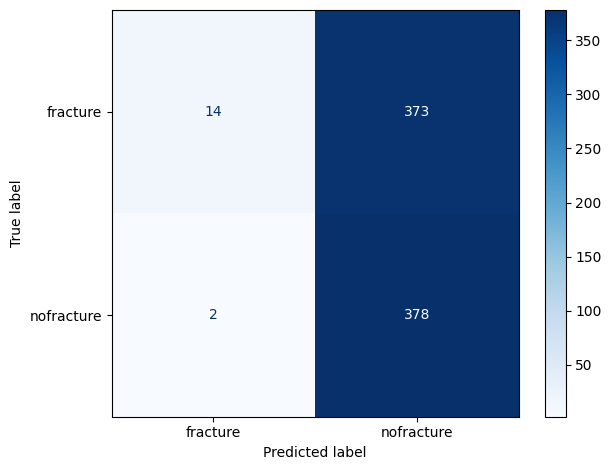

In [13]:
#Evaluating the model
test_predictions = svc.predict(test_features)
print("Accuracy en validación:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

---------------------

### **Pretrained network MobileNetV3**

In [24]:
#Load MobilNetV3
mobilenet_base = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freezing the layers
mobilenet_base.trainable = False

mobilenet_base.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_18[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 1, 16)  │          0 │ re_lu_15[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_14[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [25]:
tf.keras.utils.plot_model(mobilenet_base, show_shapes=True)

### *Loading and preprocesing images*

In [25]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [26]:
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(224, 224)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255)

### *Model 1*

In [29]:
model_mobilenet_1 = models.Sequential()
# Add pretrained networkAñadir la base preentrenada
model_mobilenet_1.add(mobilenet_base)

# Add personalized layers
model_mobilenet_1.add(layers.Flatten())  # Flatten extracted features
model_mobilenet_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_mobilenet_1.add(layers.Dropout(0.3))  #To avoid over-fitting
model_mobilenet_1.add(layers.Dense(1, activation='sigmoid'))

model_mobilenet_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,225,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,164,977 (31.15 MB)

 Trainable params: 7,225,857 (27.56 MB)

 Non-trainable params: 939,120 (3.58 MB)

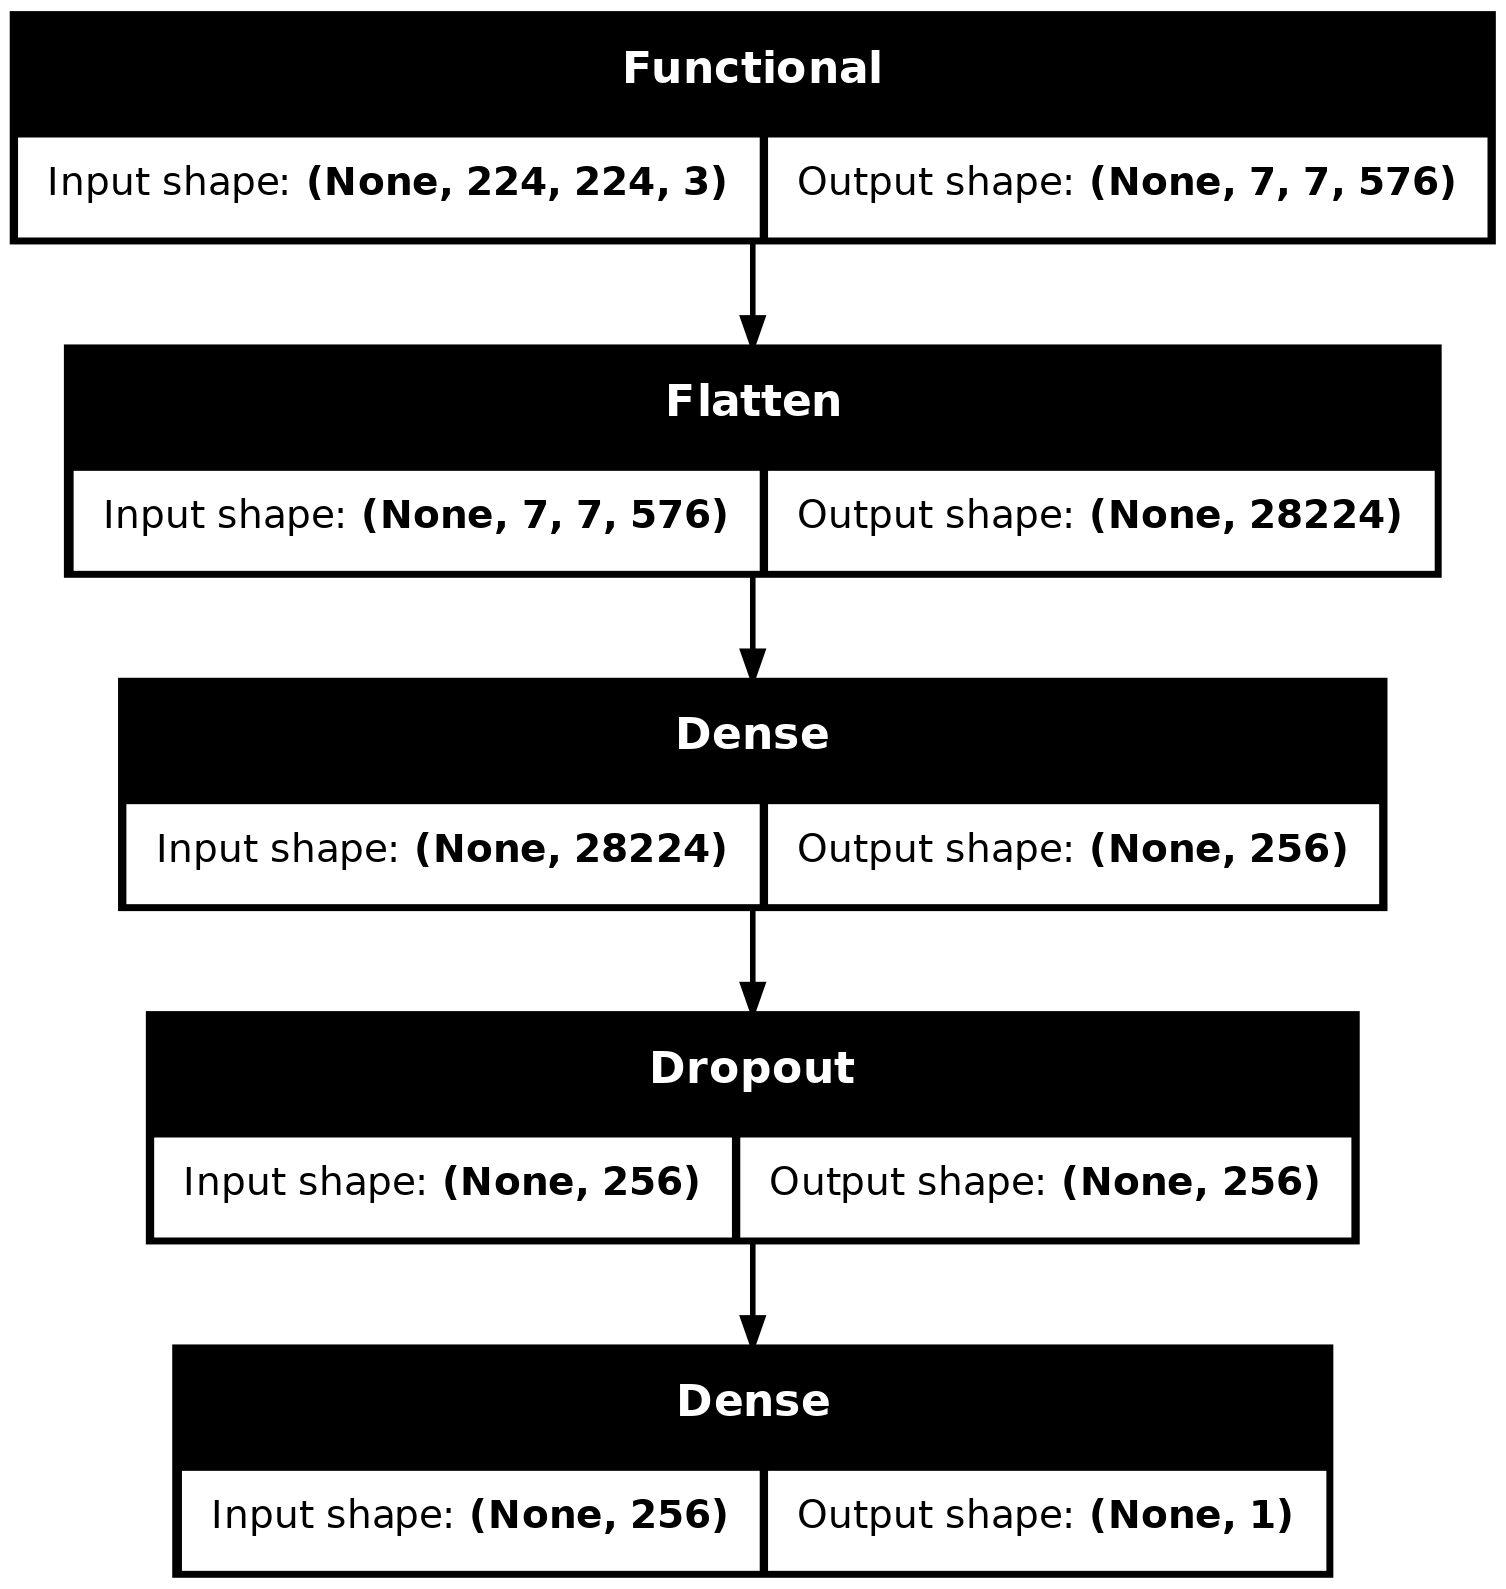

In [30]:
tf.keras.utils.plot_model(model_mobilenet_1, show_shapes=True)

In [32]:
optimizer = Adam(learning_rate=1e-5)
model_mobilenet_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_mobilenet_1, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5470 - loss: 5.5805

2025-01-21 10:24:33.557043: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.5544 - loss: 5.5325 - val_accuracy: 0.4959 - val_loss: 5.0221 - learning_rate: 1.0000e-05
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5792 - loss: 4.7936 - val_accuracy: 0.4959 - val_loss: 4.4237 - learning_rate: 1.0000e-05
Epoch 3/100
 97/130 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5842 - loss: 4.2145

2025-01-21 10:24:45.463204: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5880 - loss: 4.1790 - val_accuracy: 0.4959 - val_loss: 3.8610 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5777 - loss: 3.6680 - val_accuracy: 0.4959 - val_loss: 3.4281 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5953 - loss: 3.2378 - val_accuracy: 0.4959 - val_loss: 3.0603 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5943 - loss: 2.8899 - val_accuracy: 0.4959 - val_loss: 2.7026 - learning_rate: 1.0000e-05
Epoch 7/100
 97/130 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5944 - loss: 2.5988

2025-01-21 10:24:56.065377: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5978 - loss: 2.5805 - val_accuracy: 0.4959 - val_loss: 2.4656 - learning_rate: 1.0000e-05
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6005 - loss: 2.3323 - val_accuracy: 0.4959 - val_loss: 2.2328 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5820 - loss: 2.1261 - val_accuracy: 0.4959 - val_loss: 2.0426 - learning_rate: 1.0000e-05
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5959 - loss: 1.9449 - val_accuracy: 0.4959 - val_loss: 1.8908 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6037 - loss: 1.7976 - val_accuracy: 0.4959 - val_loss: 1.7419 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5977 - loss: 1.6820 - val_accuracy: 0.4959 - val_loss: 1.6805 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accu

2025-01-21 10:25:17.383494: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6011 - loss: 1.4310 - val_accuracy: 0.4959 - val_loss: 1.4403 - learning_rate: 1.0000e-05
Epoch 16/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5978 - loss: 1.3707 - val_accuracy: 0.4959 - val_loss: 1.4080 - learning_rate: 1.0000e-05
Epoch 17/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5913 - loss: 1.3291 - val_accuracy: 0.4959 - val_loss: 1.3589 - learning_rate: 1.0000e-05
Epoch 18/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5955 - loss: 1.2824 - val_accuracy: 0.4959 - val_loss: 1.2904 - learning_rate: 1.0000e-05
Epoch 19/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5958 - loss: 1.2425 - val_accuracy: 0.4959 - val_loss: 1.2579 - learning_rate: 1.0000e-05
Epoch 20/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5965 - loss: 1.2092 - val_accuracy: 0.4959 - val_loss: 1.2322 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - ac

2025-01-21 10:26:02.309665: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5860 - loss: 1.0062 - val_accuracy: 0.4959 - val_loss: 1.0416 - learning_rate: 1.0000e-05
Epoch 32/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6017 - loss: 0.9871 - val_accuracy: 0.4959 - val_loss: 1.0557 - learning_rate: 1.0000e-05
Epoch 33/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5962 - loss: 0.9826 - val_accuracy: 0.4959 - val_loss: 1.0116 - learning_rate: 1.0000e-05
Epoch 34/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5854 - loss: 0.9679 - val_accuracy: 0.4959 - val_loss: 0.9878 - learning_rate: 1.0000e-05
Epoch 35/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5780 - loss: 0.9591 - val_accuracy: 0.4959 - val_loss: 0.9824 - learning_rate: 1.0000e-05
Epoch 36/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5972 - loss: 0.9445 - val_accuracy: 0.4959 - val_loss: 0.9881 - learning_rate: 1.0000e-05
Epoch 37/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - ac

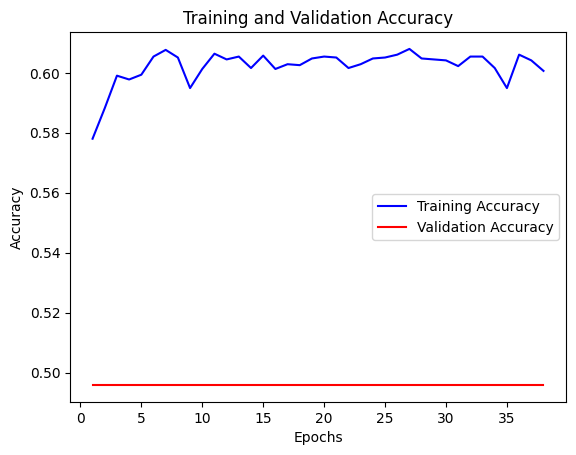

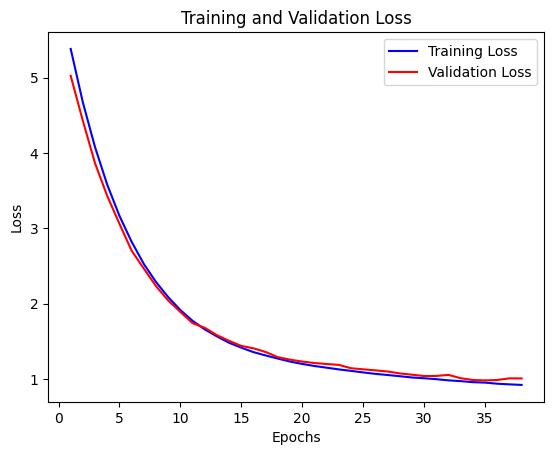

In [34]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

----------

### *Model 2*

In [8]:
model_mobilenet_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_mobilenet_2.add(mobilenet_base)

# Add personalized layers
model_mobilenet_2.add(layers.GlobalAveragePooling2D())
model_mobilenet_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_mobilenet_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_mobilenet_2.add(layers.Dense(1, activation='sigmoid'))

model_mobilenet_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,087,089 (4.15 MB)

 Trainable params: 147,969 (578.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

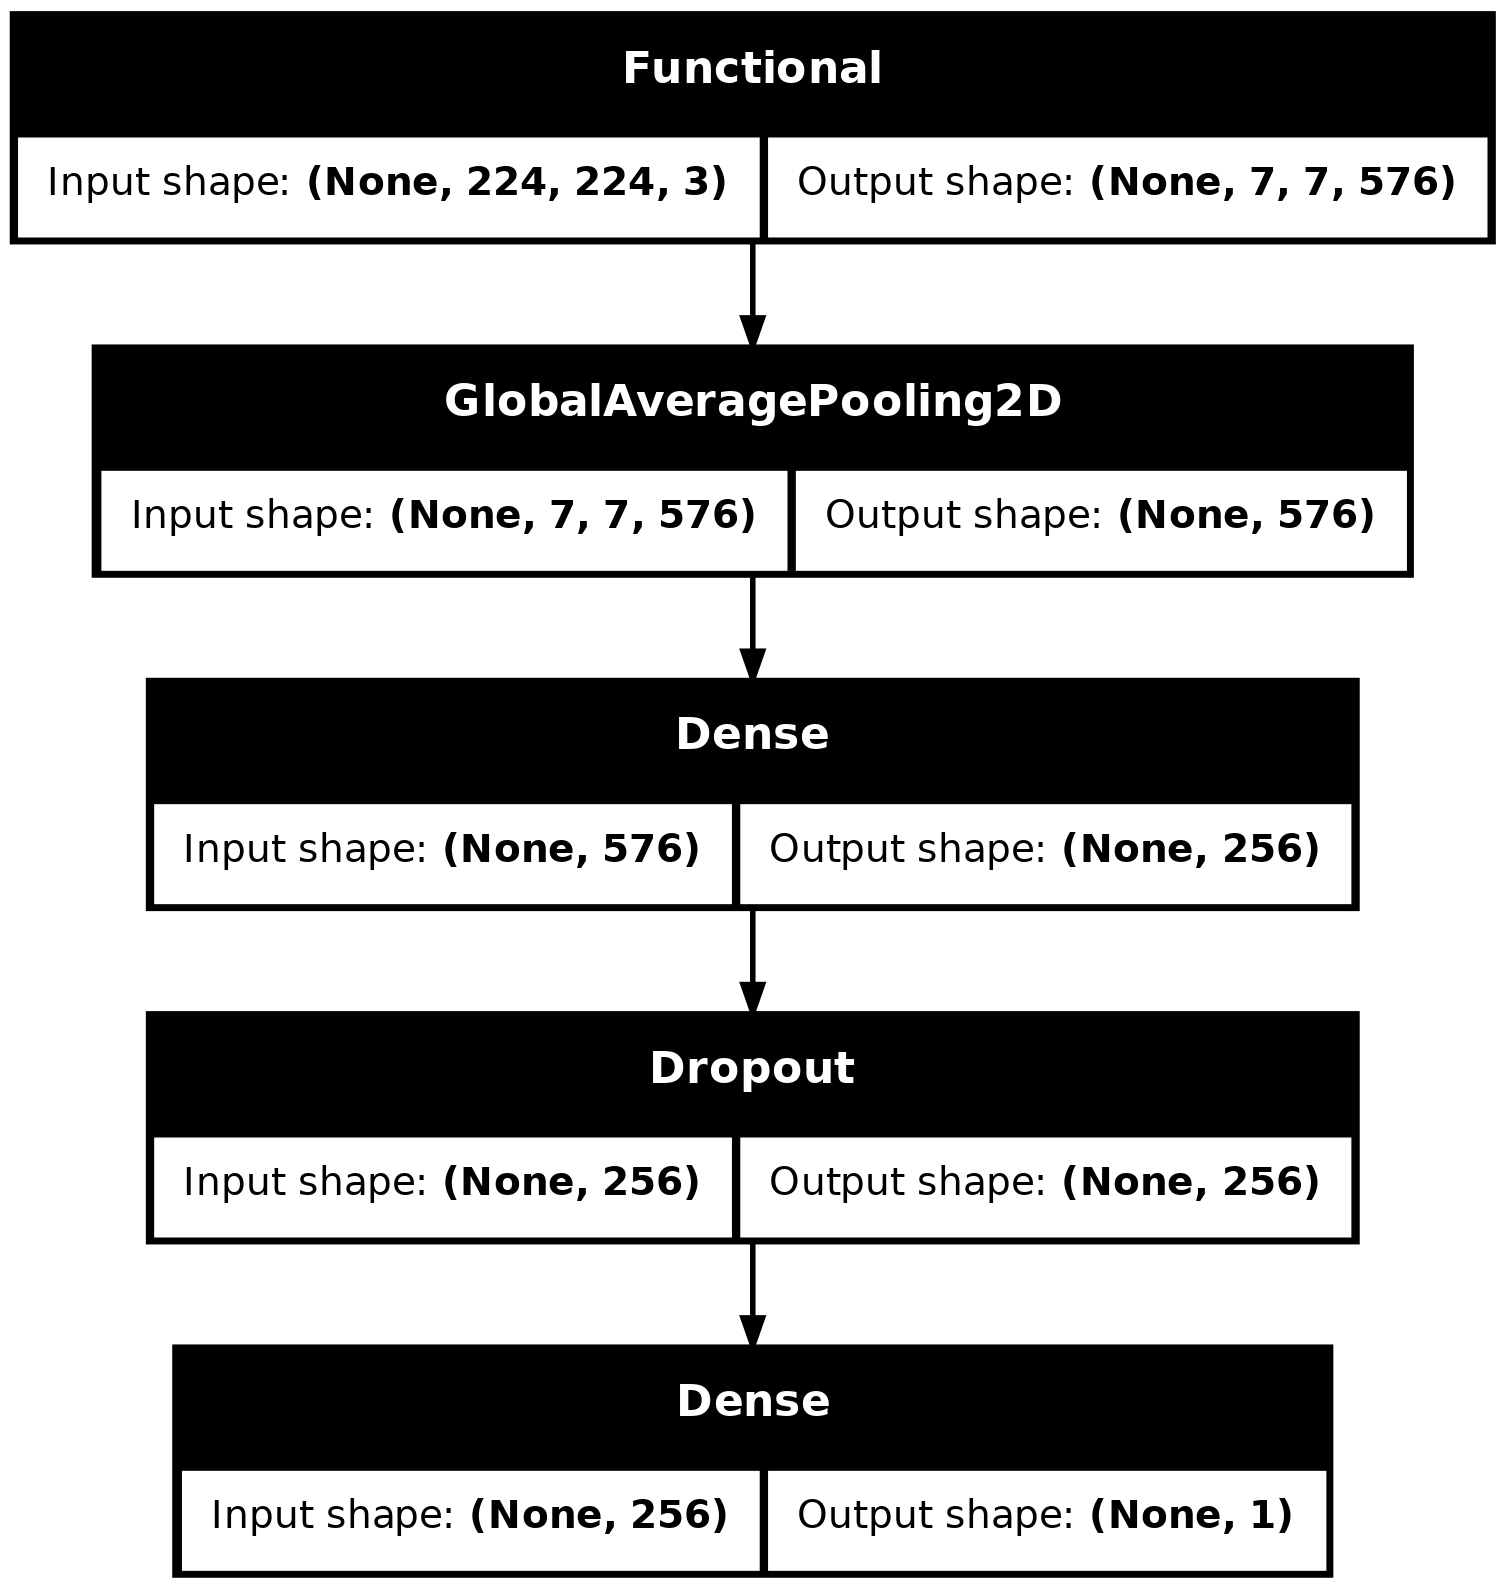

In [38]:
tf.keras.utils.plot_model(model_mobilenet_2, show_shapes=True)

In [41]:
optimizer = Adam(learning_rate=1e-5)
model_mobilenet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_mobilenet_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5333 - loss: 4.2045

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.5377 - loss: 4.1972 - val_accuracy: 0.4959 - val_loss: 4.1436 - learning_rate: 1.0000e-05
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5621 - loss: 4.0886 - val_accuracy: 0.4959 - val_loss: 4.0454 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5877 - loss: 3.9815 - val_accuracy: 0.4959 - val_loss: 3.9446 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5880 - loss: 3.8814 - val_accuracy: 0.4959 - val_loss: 3.8467 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5717 - loss: 3.7912 - val_accuracy: 0.4959 - val_loss: 3.7544 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5853 - loss: 3.6891 - val_accuracy: 0.4959 - val_loss: 3.6630 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accurac

2025-01-21 10:36:09.829484: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5866 - loss: 2.3289 - val_accuracy: 0.4959 - val_loss: 2.3263 - learning_rate: 1.0000e-05
Epoch 26/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5841 - loss: 2.2728 - val_accuracy: 0.4959 - val_loss: 2.2744 - learning_rate: 1.0000e-05
Epoch 27/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5869 - loss: 2.2229 - val_accuracy: 0.4959 - val_loss: 2.2247 - learning_rate: 1.0000e-05
Epoch 28/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5896 - loss: 2.1739 - val_accuracy: 0.4959 - val_loss: 2.1743 - learning_rate: 1.0000e-05
Epoch 29/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5931 - loss: 2.1217 - val_accuracy: 0.4959 - val_loss: 2.1262 - learning_rate: 1.0000e-05
Epoch 30/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5903 - loss: 2.0735 - val_accuracy: 0.4959 - val_loss: 2.0798 - learning_rate: 1.0000e-05
Epoch 31/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - ac

2025-01-21 10:39:01.776650: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5914 - loss: 0.8655 - val_accuracy: 0.4959 - val_loss: 0.8993 - learning_rate: 1.0000e-05
Epoch 90/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5955 - loss: 0.8586 - val_accuracy: 0.4959 - val_loss: 0.8961 - learning_rate: 1.0000e-05
Epoch 91/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5931 - loss: 0.8547 - val_accuracy: 0.4959 - val_loss: 0.8922 - learning_rate: 1.0000e-05
Epoch 92/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5962 - loss: 0.8475

2025-01-21 10:39:09.657969: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10066852914645577579
2025-01-21 10:39:09.658012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12202429157183213358


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5987 - loss: 0.8466 - val_accuracy: 0.4959 - val_loss: 0.8875 - learning_rate: 1.0000e-05
Epoch 93/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5972 - loss: 0.8426 - val_accuracy: 0.4959 - val_loss: 0.8825 - learning_rate: 1.0000e-05
Epoch 94/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5962 - loss: 0.8431

2025-01-21 10:39:14.901396: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10066852914645577579
2025-01-21 10:39:14.901422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12202429157183213358


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5986 - loss: 0.8415 - val_accuracy: 0.4959 - val_loss: 0.8791 - learning_rate: 1.0000e-05
Epoch 95/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5944 - loss: 0.8377 - val_accuracy: 0.4959 - val_loss: 0.8744 - learning_rate: 1.0000e-05
Epoch 96/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5970 - loss: 0.8319 - val_accuracy: 0.4959 - val_loss: 0.8728 - learning_rate: 1.0000e-05
Epoch 97/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5972 - loss: 0.8286 - val_accuracy: 0.4959 - val_loss: 0.8688 - learning_rate: 1.0000e-05
Epoch 98/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5947 - loss: 0.8278 - val_accuracy: 0.4959 - val_loss: 0.8651 - learning_rate: 1.0000e-05
Epoch 99/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5955 - loss: 0.8232 - val_accuracy: 0.4959 - val_loss: 0.8629 - learning_rate: 1.0000e-05
Epoch 100/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - a

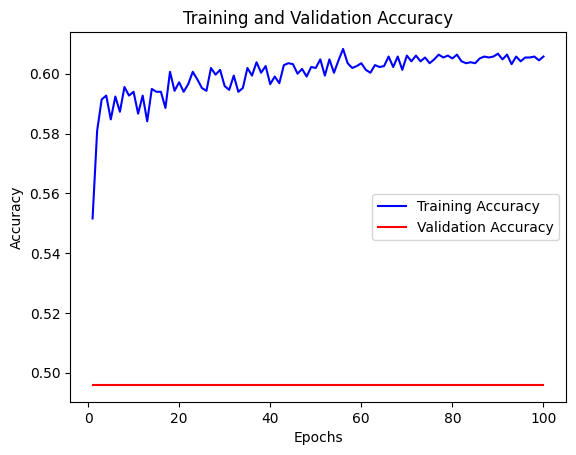

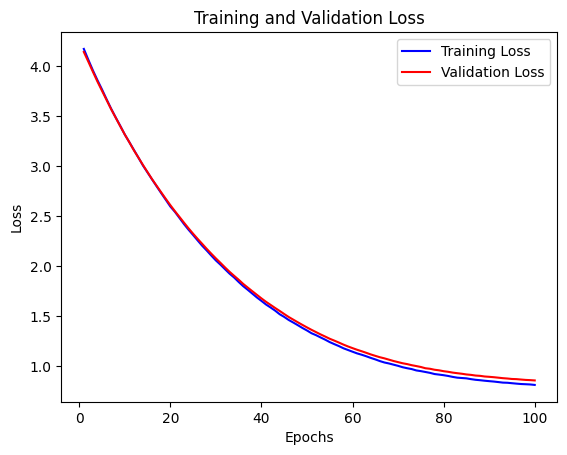

In [43]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

--------

**Model 2.1**

In [27]:
#Unfreezing the lats 20 layers
for layer in mobilenet_base.layers[-20:]:
    layer.trainable = True

In [29]:
optimizer = Adam(learning_rate=1e-5)
model_mobilenet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_mobilenet_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


I0000 00:00:1737472286.229713 1557825 service.cc:148] XLA service 0x7f4c40004a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737472286.229805 1557825 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-01-21 16:11:26.641242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737472287.500072 1557825 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/130 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4257 - loss: 4.2704

I0000 00:00:1737472293.450450 1557825 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/130 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5391 - loss: 4.2139

2025-01-21 16:11:41.311924: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-21 16:11:41.312121: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.5487 - loss: 4.2061 - val_accuracy: 0.5041 - val_loss: 4.1554 - learning_rate: 1.0000e-05
Epoch 2/100
 95/130 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5915 - loss: 4.1155

2025-01-21 16:11:50.450902: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5934 - loss: 4.1080 - val_accuracy: 0.5041 - val_loss: 4.0637 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5960 - loss: 4.0120 - val_accuracy: 0.5041 - val_loss: 3.9746 - learning_rate: 1.0000e-05
Epoch 4/100
 96/130 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5818 - loss: 3.9366

2025-01-21 16:11:55.772468: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5857 - loss: 3.9291 - val_accuracy: 0.5041 - val_loss: 3.8884 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5981 - loss: 3.8423 - val_accuracy: 0.5041 - val_loss: 3.8040 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5968 - loss: 3.7539 - val_accuracy: 0.4862 - val_loss: 3.7220 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5888 - loss: 3.6759 - val_accuracy: 0.4780 - val_loss: 3.6422 - learning_rate: 1.0000e-05
Epoch 8/100
 94/130 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5992 - loss: 3.5963

2025-01-21 16:12:06.431942: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6015 - loss: 3.5899 - val_accuracy: 0.4862 - val_loss: 3.5642 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5897 - loss: 3.5125 - val_accuracy: 0.4878 - val_loss: 3.4883 - learning_rate: 1.0000e-05
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5998 - loss: 3.4401 - val_accuracy: 0.4878 - val_loss: 3.4143 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6075 - loss: 3.3560 - val_accuracy: 0.4894 - val_loss: 3.3421 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5874 - loss: 3.2897 - val_accuracy: 0.4894 - val_loss: 3.2711 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5998 - loss: 3.2137 - val_accuracy: 0.4894 - val_loss: 3.2019 - learning_rate: 1.0000e-05
Epoch 14/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - acc

2025-01-21 16:12:27.740359: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5978 - loss: 3.0161 - val_accuracy: 0.4911 - val_loss: 3.0037 - learning_rate: 1.0000e-05
Epoch 17/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6004 - loss: 2.9516 - val_accuracy: 0.4911 - val_loss: 2.9409 - learning_rate: 1.0000e-05
Epoch 18/100
 96/130 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6002 - loss: 2.8926

2025-01-21 16:12:33.040258: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4364090554322946851


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6021 - loss: 2.8875 - val_accuracy: 0.4976 - val_loss: 2.8797 - learning_rate: 1.0000e-05
Epoch 19/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6022 - loss: 2.8311 - val_accuracy: 0.5089 - val_loss: 2.8199 - learning_rate: 1.0000e-05
Epoch 20/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6037 - loss: 2.7658 - val_accuracy: 0.5106 - val_loss: 2.7616 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6014 - loss: 2.7091 - val_accuracy: 0.5122 - val_loss: 2.7046 - learning_rate: 1.0000e-05
Epoch 22/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6002 - loss: 2.6561 - val_accuracy: 0.5041 - val_loss: 2.6497 - learning_rate: 1.0000e-05
Epoch 23/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6029 - loss: 2.6010 - val_accuracy: 0.5138 - val_loss: 2.5968 - learning_rate: 1.0000e-05
Epoch 24/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - ac

2025-01-21 16:13:12.966844: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6079 - loss: 2.1732 - val_accuracy: 0.4959 - val_loss: 2.1951 - learning_rate: 1.0000e-05
Epoch 33/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6043 - loss: 2.1329 - val_accuracy: 0.4959 - val_loss: 2.1643 - learning_rate: 1.0000e-05
Epoch 34/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5942 - loss: 2.0967 - val_accuracy: 0.4959 - val_loss: 2.1265 - learning_rate: 1.0000e-05
Epoch 35/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6025 - loss: 2.0543 - val_accuracy: 0.4959 - val_loss: 2.0943 - learning_rate: 1.0000e-05
Epoch 36/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6179 - loss: 2.0162 - val_accuracy: 0.4959 - val_loss: 2.0658 - learning_rate: 1.0000e-05
Epoch 37/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6090 - loss: 1.9823 - val_accuracy: 0.4959 - val_loss: 2.0267 - learning_rate: 1.0000e-05
Epoch 38/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - ac

2025-01-21 16:14:32.867664: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4364090554322946851
2025-01-21 16:14:32.867736: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16554318407244170991


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6121 - loss: 1.3634 - val_accuracy: 0.5268 - val_loss: 1.3867 - learning_rate: 1.0000e-05
Epoch 63/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6226 - loss: 1.3457 - val_accuracy: 0.5301 - val_loss: 1.3697 - learning_rate: 1.0000e-05
Epoch 64/100
 95/130 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6053 - loss: 1.3381

2025-01-21 16:14:38.270079: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6098 - loss: 1.3348 - val_accuracy: 0.5285 - val_loss: 1.3611 - learning_rate: 1.0000e-05
Epoch 65/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6135 - loss: 1.3188 - val_accuracy: 0.5382 - val_loss: 1.3419 - learning_rate: 1.0000e-05
Epoch 66/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6276 - loss: 1.3024 - val_accuracy: 0.5301 - val_loss: 1.3318 - learning_rate: 1.0000e-05
Epoch 67/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6158 - loss: 1.2929 - val_accuracy: 0.5350 - val_loss: 1.3142 - learning_rate: 1.0000e-05
Epoch 68/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6269 - loss: 1.2766 - val_accuracy: 0.5366 - val_loss: 1.3030 - learning_rate: 1.0000e-05
Epoch 69/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6176 - loss: 1.2609 - val_accuracy: 0.5301 - val_loss: 1.2938 - learning_rate: 1.0000e-05
Epoch 70/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - ac

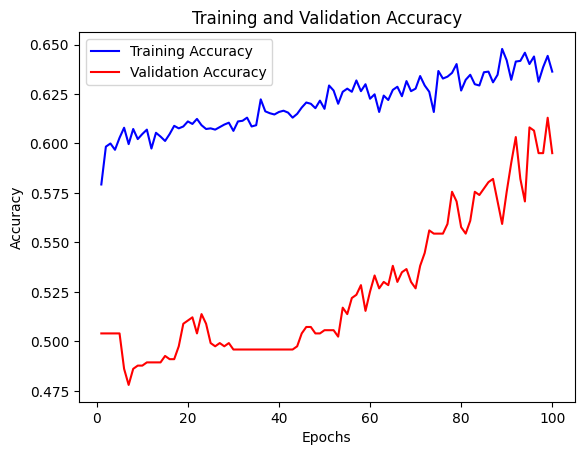

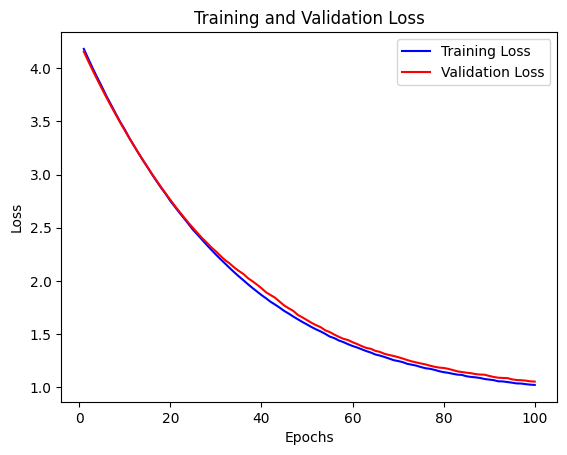

In [31]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step
Accuracy on test dataset: 0.5020

Classification Report:
               precision    recall  f1-score   support

    fracture       0.51      0.30      0.38       387
  nofracture       0.50      0.70      0.58       380

    accuracy                           0.50       767
   macro avg       0.50      0.50      0.48       767
weighted avg       0.50      0.50      0.48       767



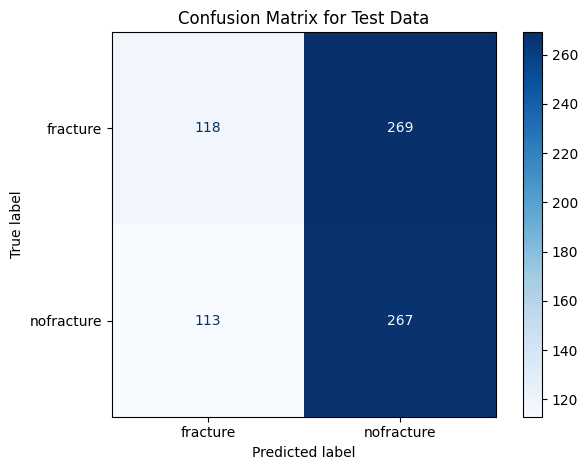

In [33]:
accuracy, class_report, cm = plot_confusion_matrix(model_mobilenet_2, test_ds, class_names = class_names)

**Model 2.2**

In [34]:
#Unfreezing the lats 50 layers
for layer in mobilenet_base.layers[-50:]:
    layer.trainable = True

In [35]:
optimizer = Adam(learning_rate=1e-5)
model_mobilenet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_mobilenet_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5596 - loss: 1.0972

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - accuracy: 0.5641 - loss: 1.0925 - val_accuracy: 0.5008 - val_loss: 1.0920 - learning_rate: 1.0000e-05
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5814 - loss: 1.0530 - val_accuracy: 0.4959 - val_loss: 1.1300 - learning_rate: 1.0000e-05
Epoch 3/100
 96/130 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5937 - loss: 1.0474

2025-01-21 16:23:08.659834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16554318407244170991


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5962 - loss: 1.0449 - val_accuracy: 0.4959 - val_loss: 1.1951 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6012 - loss: 1.0338 - val_accuracy: 0.4959 - val_loss: 1.2869 - learning_rate: 1.0000e-05


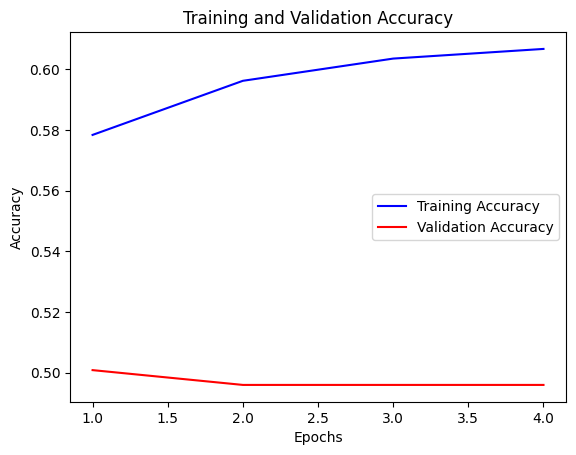

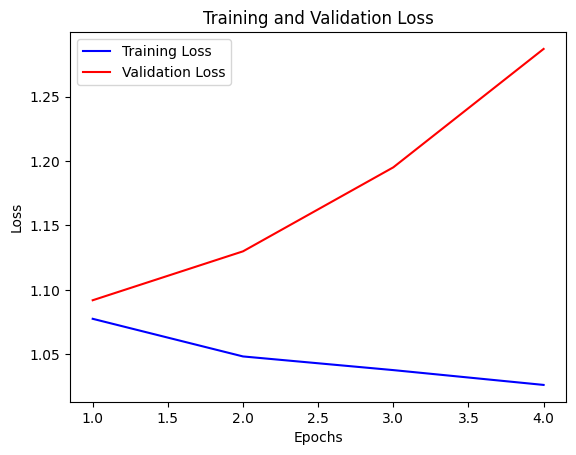

In [37]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

**Model 2.3**

In [43]:
#Unfreezing all layers
for layer in mobilenet_base.layers[:]:
    layer.trainable = True

In [44]:
optimizer = Adam(learning_rate=1e-5)
model_mobilenet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_mobilenet_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.6264 - loss: 1.0320

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 187ms/step - accuracy: 0.6296 - loss: 1.0293 - val_accuracy: 0.4959 - val_loss: 1.1564 - learning_rate: 1.0000e-05
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6449 - loss: 1.0140 - val_accuracy: 0.4959 - val_loss: 1.2236 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6559 - loss: 0.9998 - val_accuracy: 0.4959 - val_loss: 1.3015 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6624 - loss: 0.9829 - val_accuracy: 0.4959 - val_loss: 1.3132 - learning_rate: 1.0000e-05


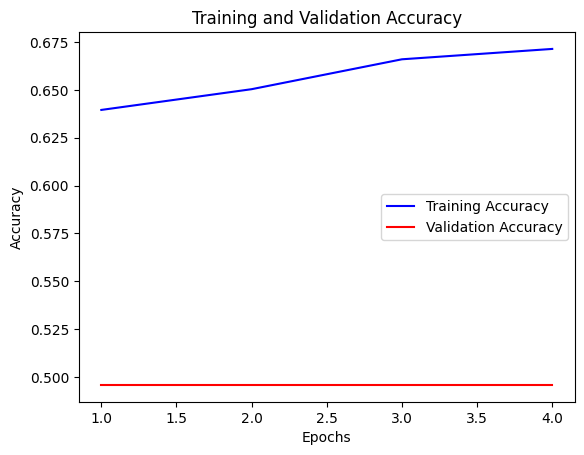

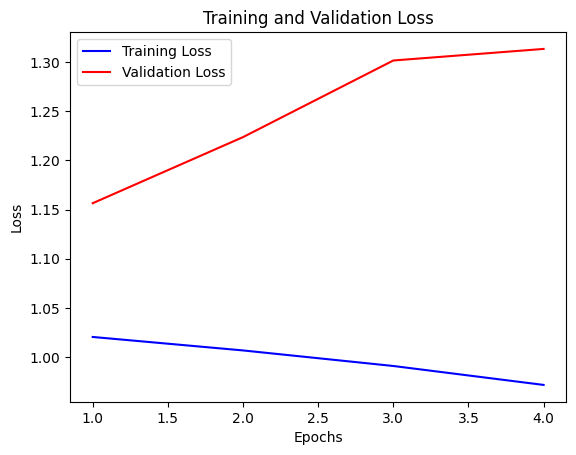

In [46]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)